<a href="https://colab.research.google.com/github/kaori-kanno/heart_recon/blob/main/recon_test_parteI_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Usar GPU T4, si se requiere de hacer algo muy pesado, el A100

In [ ]:
from google.colab import userdata
token = userdata.get('cosas-tabita')

!git clone 'https://{token}@github.com/kaori-kanno/NF-cMRI-tabita.git'
%cd NF-cMRI-tabita/

fatal: destination path 'NF-cMRI-tabita' already exists and is not an empty directory.
/content/drive/.shortcut-targets-by-id/1Hi90N_JhhwvmxCpscf9m-ipUOKjq9syo/joint_recon/Pig_2/NF-cMRI-tabita


In [ ]:
!pip install -e . # instala como librería y e permite editar

Obtaining file:///content/drive/.shortcut-targets-by-id/1Hi90N_JhhwvmxCpscf9m-ipUOKjq9syo/joint_recon/Pig_2/NF-cMRI-tabita
  Preparing metadata (setup.py) ... done
  Attempting uninstall: inrmri
    Found existing installation: inrmri 0.3.0
    Uninstalling inrmri-0.3.0:
      Successfully uninstalled inrmri-0.3.0
  Running setup.py develop for inrmri


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import inrmri

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive') # directorio de todas las carpetas
os.chdir("/content/drive/MyDrive/joint_recon/Pig_2")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
diffusion_directions.txt  kspace_real.mat   results_out3.pkl
image_imag.mat		  NF-cMRI-tabita    training_results_100k.pkl
image_real.mat		  results_out1.pkl  training_results_lr.pkl
kspace_imag.mat		  results_out2.pkl


In [ ]:
# ir = loadmat('Pig_2/image_real.mat')['image_real']
# im = loadmat('Pig_2/image_imag.mat')['image_imag']

ir_data = loadmat('/content/drive/MyDrive/joint_recon/Pig_2/image_real.mat')
im_data = loadmat('/content/drive/MyDrive/joint_recon/Pig_2/image_imag.mat')

In [ ]:
real = ir_data['image_real']
imag = im_data['image_imag']

In [ ]:
# kr = loadmat('Pig_2/kspace_real.mat')['kspace_real']
# ki = loadmat('Pig_2/kspace_imag.mat')['kspace_imag']

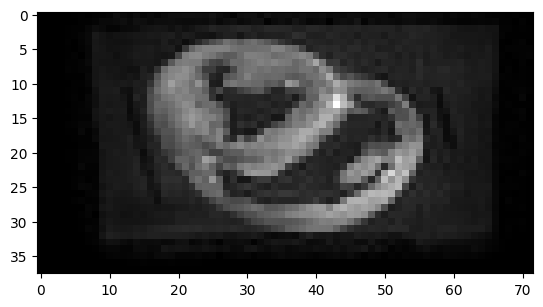

In [ ]:
image = real + 1j*imag # combinamos la parte real e imaginaria para formar la imagen completa
image = image/np.max(np.abs(image)) # se normaliza la imagen por el valor máximo

plt.imshow(np.abs(image[:,:,24,4,1]), cmap='gray') # seleccionamos el corte 24, y ciertas direcciones de difusión

In [ ]:
print(image.shape) # (x, y, z, valores_b, direcciones)

(38, 72, 49, 5, 457)


In [ ]:
# recortamos un slice de todas las imágenes en el plano XY
slice = image[:,:,24,4,:]
slice = np.transpose(slice, (2,0,1))
# slice.shape

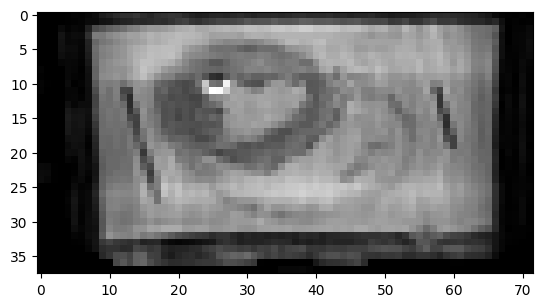

In [ ]:
M0 = image[:,:,24,0,0].copy() # imagen con b = 0 en corte 24
M0mask = np.abs(M0) > 0

plt.imshow(np.abs(M0), cmap='gray')

In [ ]:
# aplicamos Fourier en las imágenes

k_space = np.fft.fft2(slice)
k_space.shape

(457, 38, 72)

In [ ]:
n_masks = 6 # se crean máscaras en el espacio k para simular un muestreo de las imágenes
masks = []
max_lines = 11 # máximo de líneas que conservaremos en cada máscara.
bandwith = 3 # bandas a conservar al centro y a los extremos (información muy relevante en la imagen)
for i in range(n_masks):
    mask = np.zeros(k_space.shape[1:]).astype(bool) # creamos la máscara
    mask[np.arange(i,k_space.shape[1],6)] = 1 # en la máscara creada, marca como 1 (o True) cada 6 pasos, partiendo en i.


    # se conservan la banda superior e inferior como 1 o True:
    mask[-bandwith:] = 1
    mask[:bandwith] = 1

    if mask[:,0].sum() > max_lines: # si se excede el número de líneas permitidas
        idxs = np.where(mask[:,0]>0)[0] # se obtienen los índices de las filas
        order = np.argsort(np.abs(idxs - mask.shape[0]//2))
        idx = idxs[order][:(mask[:,0].sum() - max_lines)] # se ordenan las filas
        print(idx, mask[idxs[0],0])
        mask[idx,:] = 0 # se hacen 0 o False las líneas más alejadas del centro.

    masks.append(mask)
    print(mask[:,0].sum()) # imprimimos la suma de los valores que están en la fila 0 (deberían sumar max_lines)





38
38
38
38
38
38


## neural network

In [ ]:
import os

os.environ["ENABLE_PJRT_COMPATIBILITY"] = "1"

import jax.numpy as np
from jax import random, grad, jit, vmap
import jax
from jax.scipy.optimize import minimize
import numpy as onp
from jax.experimental.ode import odeint
from jax.example_libraries import optimizers
from functools import partial
from matplotlib import pyplot as plt
from jax.nn import relu
key = random.PRNGKey(0)

In [ ]:
def init_params(layers, key):
  Ws = [] # lista de matrices de pesos
  bs = [] # lista de vectores de sesgos
  for i in range(len(layers) - 1):
    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1])) # mediante glorot se definen los pesos
    key, subkey = random.split(key) # mantiene aleatoriedad controlada, mediante jax se asignan los pesos random
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(np.zeros(layers[i + 1])) # se crean los pesos en 0
  return (Ws, bs)

@jit
def forward_pass(H, params):
  """
  Esta es un MLP
  """
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = np.matmul(H, Ws[i]) + bs[i] # multiplicación de los pesos + bias
    H = np.tanh(H) # función de activación no lineal aplicada en la red
  Y = np.matmul(H, Ws[-1]) + bs[-1] # capa final sin función de activación
  return Y

def init_params_icnn(layers, key):
  Wz = [] # pesos aplicados a Z (capas intermedias)
  Wy = [] # pesos aplicados a Y (input original)
  bs = [] # bias para cada capa oculta

  std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
  key, subkey = random.split(key)
  Wy.append(random.normal(subkey, (layers[0], layers[1]))*std_glorot)

  for i in range(1,len(layers) - 1):
    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Wz.append(-3 + random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot) #Wz recibe pesos inicializados con ruido negativo (-3 + random...) para garantizar valores pequeños
    Wy.append(random.normal(subkey, (layers[0], layers[i + 1]))*std_glorot) # se conecta la capa de entrada, 0, con las capas ocultas
    bs.append(np.zeros(layers[i + 1]))
  return (Wz, Wy, bs)

@jit
def icnn_forwardpass(Y, params): # se recorren hacia adelante las capas
  """
  Esta es un ICNN
  """
  Wz, Wy, bs = params
  N_layers = len(Wy)
  Z = relu(np.matmul(Y, Wy[0]) + bs[0])  # esta es la capa de entrada Y
  for i in range(1, N_layers - 1): # aquí se recorren las capas intermedias
    Z = np.matmul(Z, np.exp(Wz[i-1])) + np.matmul(Y, Wy[i]) + bs[i]
    Z = relu(Z) # se da una función de activación
  Z = np.matmul(Z, np.exp(Wz[-1])) + np.matmul(Y, Wy[-1]) + bs[-1]  # última capa, sin activación no lineal
  return Z


@jit
def ff_forwardpass_B(X, params, B):
  """
  Aplicar Fourier a la data de entrada x.
  B es una matriz
  """
  angles = 2*np.pi*vmap(np.dot, in_axes = (None, 0))(B, X) # calcula el producto punto entre cada fila de X y B, B @ X.T
  # estos son los ángulos de los features
  gamma = np.concatenate((np.sin(angles), np.cos(angles)), axis = 1) # Fourier Feature Mapping, un truco para mapear tus datos a un espacio más rico.
  return forward_pass(gamma, params)  #  se pasa gamma por el MLP forward_pass

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)  # extrae los parámetros
    g = grad(loss)(params, X_batch, Y_batch)  # calcula el gradiente de la función de pérdida respecto a los parámetros
    return opt_update(i, g, opt_state) # actualiza los parámetros con un tamaño adecuado

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    """
    Aquí entrenamos el modelo para varias iteraciones con batches de data X e Y que se crean aquí
    """
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        # idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False) # toma un batch aleatorio
        opt_state = step(loss, it, opt_state, X, Y) # actualiza los parámetros con step
       # opt_state = step(loss, it, opt_state, X, Y)
        if it % 100 == 0:  # cada 100 iteraciones:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y) # train_loss_value = loss(params, X[idx_batch], Y[idx_batch])
            train_loss.append(train_loss_value)  # mide la pérdida del batch
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return opt_state, train_loss, val_loss

def train_batch(loss, Xb, Yb, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    it = 0
    while it < nIter: # itera en los batches
        for X, Y in zip(Xb, Yb): # Xb, Yb son listas de batches
          opt_state = step(loss, it, opt_state, X, Y)
          it += 1
          if it % 100 == 0:
              params = get_params(opt_state)
              train_loss_value = loss(params, X, Y)
              train_loss.append(train_loss_value)
              to_print = "it %i, train loss = %e" % (it, train_loss_value)
              print(to_print)
    return get_params(opt_state), train_loss, val_loss

def create_batches(input, output, batch_size):
    """
    Divide los datos en mini-batches y los devuelve
    """
    # Ensure input and output have the same first dimension length
    assert input.shape[0] == output.shape[0], "Input and output must have the same number of samples"

    num_samples = input.shape[0]  # número de muestras totales

    # Shuffle indices
    shuffled_indices = random.permutation(jax.random.PRNGKey(0), num_samples) # Crea un orden aleatorio de los índices (0 a num_samples-1)
    input_shuffled = input[shuffled_indices]
    output_shuffled = output[shuffled_indices] # reordena las muestras del output

    # Split the data into batches
    # Devuelve listas con batches de X e Y, listas de tamaño num_batches.
    input_batches = np.array_split(input_shuffled, num_samples // batch_size)
    output_batches = np.array_split(output_shuffled, num_samples // batch_size)

    return input_batches, output_batches




In [ ]:
@jit
def cartesian_to_spherical(x):
    """
    Se toma un vector 3D y se convierte a esféricas
    """
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    theta = np.arccos(x[2] / r)  # polar angle
    phi = np.arctan2(x[1], x[0])    # azimuthal angle
    return r, theta, phi

In [ ]:
# cargamos las direcciones de gradiente de difusión, son 457

dirs = onp.genfromtxt('diffusion_directions.txt', delimiter=';')

R, Theta, Phi= vmap(cartesian_to_spherical)(dirs) # vmap opera sobre un batch o conjunto de datos la operación dada

As = np.cos(Theta) # proyección en z de las direcciones
Bs = np.cos(Phi) # proyección en el plano XY



Acabamos de procesar direcciones existentes, podemos ahora mapear direcciones ideales:

In [ ]:
import mpl_toolkits.mplot3d

num_pts = 24
b_value = 6500
indices = np.arange(0, num_pts, dtype=float) + 0.5  # entrega valores igualmente espaciados en el rango (0, num_pts)
# sumamos 0.5 para que no sean los puntos de los extremos o los polos de la esfera.

phi = np.arccos(1 - 2*indices/num_pts) # esfera de Fibonacci
theta = np.pi * (1 + 5**0.5) * indices # esfera de Fibonacci, espiral con proporción áurea

# convertimos de esféricas a cartesianas con r = 1
# fórmula de fibonachi para una esfera donde los puntos están equidistantes repartidos.
x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)


# solo necesitamos mapear en una semi-esfera por simetría:
x_half = x[np.where(z >=0)]
y_half = y[np.where(z >=0)]
z_half = z[np.where(z >=0)]
b_value = np.repeat(b_value,x_half.shape[0])  # añadimos b al arreglo



directions = np.array([x_half,z_half,y_half]).transpose() # vector de dirección en 3d, (x, z, y)

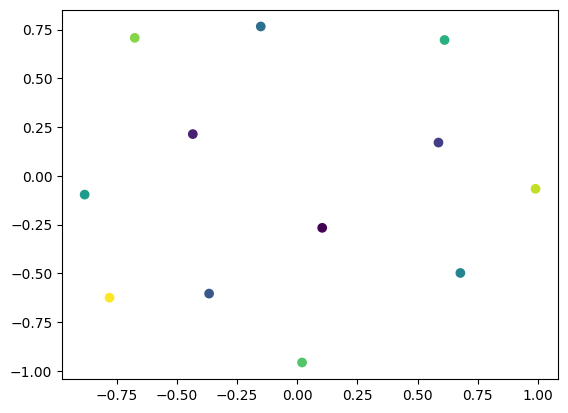

In [ ]:
plt.scatter(x_half, y_half, c = np.arange(x_half.shape[0]))

Array([0.99878776, 0.997787  , 0.99924225, 0.9993435 , 0.9996348 ,
       0.99877995, 0.99890304, 0.9988387 , 0.99909306, 0.9991267 ,
       0.9997292 , 0.99772215], dtype=float32)

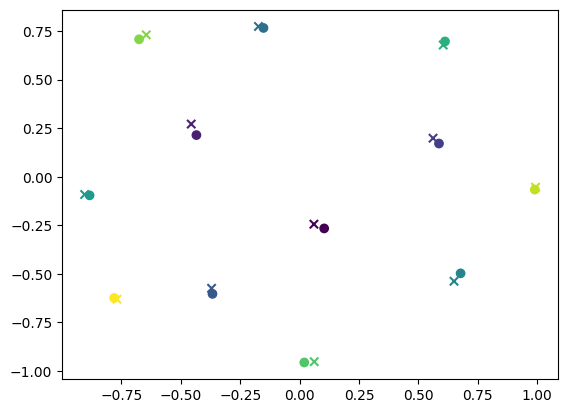

In [ ]:
# calculamos el producto punto entre cada dirección dir creada de direction con las otras direcciones dirs del scaner
ort = vmap(lambda dir, dirs: np.dot(dir,dirs), in_axes=(None, 0))(directions, dirs)


selected_dirs = np.argmax(ort, axis = 0) # el de mayor producto punto será la dirección más cercana
selected_dirs_vec = dirs[selected_dirs] # guardamos esas direcciones

plt.scatter(x_half, y_half, c = np.arange(x_half.shape[0]))
plt.scatter(selected_dirs_vec[:,0], selected_dirs_vec[:,2], c = np.arange(x_half.shape[0]), marker = 'x')
np.max(ort, axis = 0)

In [ ]:
# coordenadas del sistema:
Nx = k_space.shape[1] # tamaño de la transformada de fourier en x
Ny = k_space.shape[2] # tamaño de la transformada de fourier en y
x = np.arange(Nx)/(Nx - 1)*2 - 1 # normaliza las coordenadas Nx a valores entre -1 y 1
y = np.arange(Ny)/(Nx - 1)*2 - 1 # [0 a Ny-1]/(Ny-1) = [0 - 1]

X, Y = np.meshgrid(x, y, indexing = 'ij') # X, Y = np.meshgrid(x, y)
Xall = np.c_[X.flatten(), Y.flatten()] # aplana y concatena X con Y

# creamos las máscaras
masks = np.array(masks)
masks_rep = np.concatenate((masks, masks), axis = 0)  # se le agregan máscaras # masks_rep = np.concatenate((masks, masks[:3]), axis = 0)

input = []
output = []

for i,dir_idx in enumerate(selected_dirs): # son 9 puntos en selected_dirs
    input.append(np.c_[Xall, np.ones(Xall.shape[0])*As[dir_idx], np.ones(Xall.shape[0])*Bs[dir_idx]]) # (xs, ys, cos(th), cos(phi))
input = np.array(input)
# recordar que Xall.shape = (Nx * Ny, 2) y As[dir_idx] sería la dirección de un vector de selected_dirs



print(k_space[selected_dirs].shape) # (num_puntos 12, x, y)
output = k_space[selected_dirs][masks_rep] # se le aplica la máscara a las direcciones seleccionados.
print(input.shape, output.shape) # (num_puntos 12, num_puntos_visibles Nx*Ny, 4 (x, y, cos, cos)) y un valor


(12, 38, 72)
(12, 2736, 4) (32832,)


In [ ]:
masks = np.array(masks)

@jit
def forward_model(X, params):
    I = ff_forwardpass(X, params) # pasa por la función de más abajo que lleva a ff_forwwardpass_mixed
    I = I[:,0] + 1j*I[:,1] # se convierte la imagen a una compleja
    I = I.reshape((Nx, Ny)) # I = I.reshape(mask.shape) # se reconstruye la imagen
    k_space = np.fft.fft2(I) # transforma a k-space
    return k_space

n_pix = k_space.shape[1]*k_space.shape[2]

# @jit
# def loss(params, input, Y):

#   k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
#   return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix


@jit
def ff_forwardpass_mixed(X, params, B):
  angles = 2*np.pi*vmap(np.dot, in_axes = (None, 0))(B, X[:,:2]) # 2pi * (proyecciones)
  input = np.concatenate((np.sin(angles), np.cos(angles), X[:,2:]), axis = 1)
  return forward_pass(input, params)

sigma = 0.15
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)

layers = [2*N_ff+2, 256, 256,256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 256 neuronas y 2 neuronas de salida para parte real e im
params = init_params(layers, key)



In [ ]:
def psnr(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  print(k_spaces.shape)
  mse = np.mean(np.abs((k_spaces - Y))**2/(n_pix))
  max_value = np.max(np.abs(Y))
  return 20 * np.log10(max_value / (np.sqrt(mse)))

## Simple train try

In [ ]:
from inrmri.basic_nn import simple_train
import optax

In [ ]:
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
batch_size = 12
nIter = 1000 #1000

random_seed  = 0
key_split, key_B, key_init, key_train = random.split(random.PRNGKey(random_seed), 4)
output = output.reshape((12, 792))
trainset = (input, output)

ValueError: cannot reshape array of size 32832 into shape (12,792)

In [ ]:
input.shape, output.shape

In [ ]:
from inrmri.basic_nn import simple_train

from tqdm import tqdm


@jit
def loss(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  reshape = k_spaces[masks_rep].reshape((12, 792))
  return np.mean(np.abs((np.squeeze(reshape) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix


# def simple_train(loss, X, Y, params, optimizer, key, batch_size = 5000, nIter = 5000):
#     opt_state = optimizer.init(params)

#     #@partial(jax.jit, static_argnums=(3,)) # yo diria que 0
#     def step(loss, params, opt_state, batchX, batchY):
#         loss_value, grads = jax.value_and_grad(loss)(params, batchX, batchY)
#         updates, opt_state = optimizer.update(grads, opt_state, params)
#         params = optax.apply_updates(params, updates)
#         return params, opt_state, loss_value

#     train_loss = []
#     best_loss = np.inf
#     iterations = []
#     for it in tqdm(range(nIter), desc='train iter', leave=True):
#         key, subkey = random.split(key)
#         idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,))#, replace = False)#
#         params, opt_state, train_loss_value = step(loss, params, opt_state, X[idx_batch], Y[idx_batch])
#         if train_loss_value < best_loss:
#             best_loss = train_loss_value
#             best_param = params
#         if it % 100 == 0:
#             train_loss.append(train_loss_value)
#             to_print = " it %i, train loss = %e" % (it, train_loss_value)
#             print(to_print)

#             iterations.append(it)
#     results = {
#       'last_param': params,
#       'best_param': best_param,
#       'train_loss': train_loss,
#       'best_loss': best_loss,
#       'iterations': iterations
#     }
#     return results

# results = simple_train(loss, *trainset, params,  optimizer, key_train, batch_size = batch_size, nIter = nIter)

In [ ]:
# loss(results['best_param'], input, output)

In [ ]:
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
batch_size = 12 # cambiar luego batch_size
nIter = 100000

random_seed  = 0
key_split, key_B, key_init, key_train = random.split(random.PRNGKey(random_seed), 4)
output = output.reshape((12, 792))
trainset = (input, output)

layers = [2*N_ff+2, 256, 256,256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 256 neuronas y 2 neuronas de salida para parte real e im
params = init_params(layers, key)

# results = simple_train(loss, *trainset, params,  optimizer, key_train, batch_size = batch_size, nIter = nIter)

In [ ]:
import pickle

# with open("training_results_100k.pkl", "wb") as f:
#     pickle.dump(results, f)

In [ ]:
with open("training_results_100k.pkl", "rb") as f:
    results = pickle.load(f)


In [ ]:
@jit
def loss(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  reshape = k_spaces[masks_rep].reshape((12, 792))
  return np.mean(np.abs((np.squeeze(reshape) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix



loss(results['best_param'], input, output)

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, results['last_param'])
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
from inrmri.metrics import ssim_metric, mean_ssim

In [ ]:
psnr(results['best_param'], input, k_space[selected_dirs])

In [ ]:
from skimage.metrics import structural_similarity as ssim


for i, idx in enumerate(selected_dirs):
    plt.subplot(4, 3, i+1)

    inp = input[i]
    Img = ff_forwardpass(inp, results['best_param'])
    Img = Img[:, 0] + 1j * Img[:, 1]
    I_img = np.abs(Img).reshape((Nx, Ny))

    gt_img = np.abs(slice[idx])
    img = gt_img  # ya tiene la forma correcta

    diff = I_img - img
    ssim_val = ssim(I_img, img, data_range=img.max() - img.min())

    plt.imshow(diff, cmap='gray')
    plt.title(f'SSIM: {ssim_val:.3f}')
    plt.axis('off')

plt.tight_layout()

In [ ]:
learning_rate = optimizers.exponential_decay(5e-3, decay_steps=1000, decay_rate=0.99)
optimizer = optax.adam(learning_rate)
batch_size = 12 # cambiar luego batch_size
nIter = 60000

random_seed  = 0
key_split, key_B, key_init, key_train = random.split(random.PRNGKey(random_seed), 4)
output = k_space[selected_dirs][masks_rep]
output = output.reshape((12, 792))
trainset = (input, output)

layers = [2*N_ff+2, 256, 256,256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 256 neuronas y 2 neuronas de salida para parte real e im
params = init_params(layers, key)

# results_lr = simple_train(loss, *trainset, params,  optimizer, key_train, batch_size = batch_size, nIter = nIter)

In [ ]:
# with open("training_results_lr.pkl", "wb") as f:
#     pickle.dump(results_lr, f)

In [ ]:
with open("training_results_lr.pkl", "rb") as f:
    results_lr = pickle.load(f)


In [ ]:
loss(results_lr['best_param'], input, output)

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, results_lr['last_param'])
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax.numpy.fft import ifft2, ifftshift

output = k_space[selected_dirs][masks_rep]

# Parámetros
num_dirs = 12
vals_per_image = output.shape[0] // num_dirs
H, W = 38, 72

reconstructed_images = []

for i in range(12):
    mask_i = masks_rep[i].reshape(-1)  # (2736,)
    img_vals = output[i * vals_per_image : (i + 1) * vals_per_image].reshape(-1)  # (792,)
    img = np.zeros(H * W, dtype=output.dtype)  # (2736,)
    img = img.at[mask_i].set(img_vals)
    img = img.reshape(H, W)

    img_k = ifftshift(img)  # centrar
    img_spatial = jnp.abs(ifft2(img_k))  # convertir a imagen espacial

    reconstructed_images.append(img_spatial)

fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i, ax in enumerate(axs.flat):
    ax.imshow(reconstructed_images[i], cmap='gray')
    ax.set_title(f'Dir {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()


Probamos con otro output y cambiando así la función de pérdida

In [ ]:
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
batch_size = 12
nIter = 60000

random_seed  = 0
key_split, key_B, key_init, key_train = random.split(random.PRNGKey(random_seed), 4)
output = k_space[selected_dirs][masks_rep]

In [ ]:
import jax.numpy as jnp

vals_per_image = 792
reconstructed_output = []

for i in range(12):
    img_vals = output[i * vals_per_image : (i + 1) * vals_per_image].reshape(-1)  # (792,)
    reconstructed_output.append(img_vals)

# Convertir a array de shape (12, 792)
reconstructed_output = jnp.stack(reconstructed_output, axis=0)
print(reconstructed_output.shape)

In [ ]:
from inrmri.basic_nn import simple_train

from tqdm import tqdm


@jit
def loss(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  reshape = k_spaces[masks_rep].reshape((12, 792))
  return np.mean(np.abs((np.squeeze(reshape) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix

trainset = (input, reconstructed_output)
print(reconstructed_output.shape)

# results_out1 = simple_train(loss, *trainset, params,  optimizer, key_train, batch_size = batch_size, nIter = nIter)

In [ ]:
# volver a probar pero ahora con el loss cambiando el output

@jit
def loss(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  Y = Y.reshape(-1) # cambiar esto
  print(Y.shape)
  return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix


trainset = (input, reconstructed_output)
print(reconstructed_output.shape)

# results_out2 = simple_train(loss, *trainset, params,  optimizer, key_train, batch_size = batch_size, nIter = nIter)

In [ ]:
with open("results_out1.pkl", "rb") as f:
    results_out1 = pickle.load(f)

In [ ]:
with open("results_out2.pkl", "rb") as f:
    results_out2 = pickle.load(f)


In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, results_out2['last_param'])
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, results_out1['last_param'])
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
loss(results_out2['last_param'], input, output)

Métricas de conectividad

In [ ]:
def psnr(input, output):

  mse = np.mean(np.abs((input - output))**2/(n_pix))
  max_value = np.max(np.abs(output))
  return 20 * np.log10(max_value / (np.sqrt(mse)))

In [ ]:
def mse(input, output):
  return np.sqrt(((input - output) ** 2/(n_pix)).mean())

In [ ]:
from inrmri.metrics import ssim_metric, mean_ssim, mutual_information_metric
from inrmri.basic_nn import psnr
from image_similarity_measures.quality_metrics import fsim, rmse

for i, idx in enumerate(selected_dirs):
    plt.subplot(4, 3, i+1)

    # Imagen ground truth
    gt_image = np.abs(slice[idx]).squeeze()  # (38, 72)

    # Imagen reconstruida
    inp = input[i]
    I = ff_forwardpass(inp, results['last_param'])
    I = I[:, 0] + 1j * I[:, 1]
    I_image = np.abs(I).reshape((Nx, Ny))  # también (38, 72)

    # Mostrar diferencia
    diff = I_image - gt_image
    plt.imshow(diff, cmap='gray')
    plt.axis('off')

    # Calcular métricas
    val1 = ssim_metric(I_image, gt_image)
    val2 = mean_ssim(I_image, gt_image)
    val3 = psnr(I_image, gt_image)
    # val4 no corre con estas imágenes, rsme por algún motivo solo me corre con imágenes en 3 dim y me da 0 en todo
    val5 = rmse(I_image[..., None].astype(onp.float32), gt_image[..., None].astype(onp.float32))

    ssim_val = ssim(I_img, gt_image, data_range=gt_image.max() - gt_image.min())

    print(f"Slice {i}: SSIM={val1:.3f}, Mean SSIM={val2:.3f}, PSNR={val3:.3f}, MSE={val5:.1f}")
    print(f"PSNR otro método: {psnr(I_image, gt_image)}")
    print(f"SSIM otro método: {ssim_val}")
    print(f"RMSE otro método: {mse(I_image, gt_image)}")


cambiemos el número de batches

probemos otras configuraciones

### Máscara vacía:

In [ ]:
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
batch_size = 12
nIter = 60000 #1000

random_seed  = 0
key_split, key_B, key_init, key_train = random.split(random.PRNGKey(random_seed), 4)
output = output.reshape((12, 2736))
trainset = (input, output)

@jit
def loss(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  Y = Y.reshape(-1) # cambiar esto
  print(Y.shape)
  return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix


In [ ]:
# results_out3 = simple_train(loss, *trainset, params,  optimizer, key_train, batch_size = batch_size, nIter = nIter)

train iter:   0%|          | 4/60000 [00:01<3:41:00,  4.52it/s] 

 it 0, train loss = 7.558621e-01


train iter:   0%|          | 106/60000 [00:05<36:54, 27.05it/s]

 it 100, train loss = 2.445241e-03


train iter:   0%|          | 204/60000 [00:09<1:00:29, 16.48it/s]

 it 200, train loss = 3.628124e-03


train iter:   1%|          | 304/60000 [00:15<39:36, 25.11it/s]

 it 300, train loss = 2.100095e-03


train iter:   1%|          | 404/60000 [00:20<39:56, 24.87it/s]

 it 400, train loss = 1.978457e-03


train iter:   1%|          | 503/60000 [00:27<1:08:06, 14.56it/s]

 it 500, train loss = 2.472361e-03


train iter:   1%|          | 602/60000 [00:35<1:25:39, 11.56it/s]

 it 600, train loss = 2.555673e-03


train iter:   1%|          | 704/60000 [00:41<38:54, 25.39it/s]

 it 700, train loss = 2.703835e-03


train iter:   1%|▏         | 806/60000 [00:45<37:46, 26.12it/s]

 it 800, train loss = 3.257205e-03


train iter:   2%|▏         | 904/60000 [00:49<54:15, 18.15it/s]

 it 900, train loss = 3.154434e-03


train iter:   2%|▏         | 1006/60000 [00:54<38:49, 25.32it/s]

 it 1000, train loss = 2.492909e-03


train iter:   2%|▏         | 1105/60000 [00:58<36:39, 26.77it/s]

 it 1100, train loss = 2.124819e-03


train iter:   2%|▏         | 1204/60000 [01:01<36:46, 26.64it/s]

 it 1200, train loss = 2.430141e-03


train iter:   2%|▏         | 1303/60000 [01:07<38:50, 25.19it/s]

 it 1300, train loss = 2.371222e-03


train iter:   2%|▏         | 1402/60000 [01:10<43:08, 22.64it/s]

 it 1400, train loss = 2.013596e-03


train iter:   3%|▎         | 1503/60000 [01:16<1:01:23, 15.88it/s]

 it 1500, train loss = 1.317130e-03


train iter:   3%|▎         | 1604/60000 [01:21<36:19, 26.79it/s]

 it 1600, train loss = 2.077351e-03


train iter:   3%|▎         | 1706/60000 [01:25<37:12, 26.11it/s]

 it 1700, train loss = 1.530952e-03


train iter:   3%|▎         | 1803/60000 [01:29<54:45, 17.71it/s]

 it 1800, train loss = 1.523573e-03


train iter:   3%|▎         | 1904/60000 [01:34<39:11, 24.71it/s]

 it 1900, train loss = 1.289314e-03


train iter:   3%|▎         | 2006/60000 [01:38<35:55, 26.90it/s]

 it 2000, train loss = 1.549660e-03


train iter:   4%|▎         | 2102/60000 [01:41<40:29, 23.83it/s]

 it 2100, train loss = 1.529985e-03


train iter:   4%|▎         | 2204/60000 [01:47<38:29, 25.03it/s]

 it 2200, train loss = 1.162069e-03


train iter:   4%|▍         | 2306/60000 [01:51<36:30, 26.34it/s]

 it 2300, train loss = 1.458384e-03


train iter:   4%|▍         | 2405/60000 [01:54<36:02, 26.63it/s]

 it 2400, train loss = 1.126639e-03


train iter:   4%|▍         | 2505/60000 [02:00<37:14, 25.73it/s]

 it 2500, train loss = 1.195272e-03


train iter:   4%|▍         | 2604/60000 [02:03<38:24, 24.90it/s]

 it 2600, train loss = 1.177052e-03


train iter:   5%|▍         | 2706/60000 [02:08<38:59, 24.49it/s]

 it 2700, train loss = 1.214440e-03


train iter:   5%|▍         | 2806/60000 [02:13<37:41, 25.29it/s]

 it 2800, train loss = 8.513224e-04


train iter:   5%|▍         | 2905/60000 [02:17<36:49, 25.84it/s]

 it 2900, train loss = 8.387625e-04


train iter:   5%|▌         | 3004/60000 [02:21<35:06, 27.05it/s]

 it 3000, train loss = 1.096157e-03


train iter:   5%|▌         | 3104/60000 [02:26<36:48, 25.77it/s]

 it 3100, train loss = 9.283252e-04


train iter:   5%|▌         | 3206/60000 [02:30<35:13, 26.87it/s]

 it 3200, train loss = 8.033641e-04


train iter:   6%|▌         | 3305/60000 [02:33<37:03, 25.50it/s]

 it 3300, train loss = 1.010014e-03


train iter:   6%|▌         | 3405/60000 [02:39<38:57, 24.21it/s]

 it 3400, train loss = 1.231354e-03


train iter:   6%|▌         | 3504/60000 [02:42<36:17, 25.94it/s]

 it 3500, train loss = 1.460755e-03


train iter:   6%|▌         | 3606/60000 [02:46<36:18, 25.89it/s]

 it 3600, train loss = 7.662197e-04


train iter:   6%|▌         | 3704/60000 [02:52<41:56, 22.37it/s]

 it 3700, train loss = 8.460768e-04


train iter:   6%|▋         | 3806/60000 [02:56<36:03, 25.97it/s]

 it 3800, train loss = 9.189737e-04


train iter:   7%|▋         | 3905/60000 [02:59<36:28, 25.63it/s]

 it 3900, train loss = 8.944933e-04


train iter:   7%|▋         | 4004/60000 [03:05<43:40, 21.37it/s]

 it 4000, train loss = 7.928853e-04


train iter:   7%|▋         | 4106/60000 [03:09<34:55, 26.67it/s]

 it 4100, train loss = 6.038612e-04


train iter:   7%|▋         | 4205/60000 [03:12<35:14, 26.39it/s]

 it 4200, train loss = 6.876879e-04


train iter:   7%|▋         | 4304/60000 [03:18<49:03, 18.92it/s]

 it 4300, train loss = 7.006684e-04


train iter:   7%|▋         | 4406/60000 [03:22<34:12, 27.09it/s]

 it 4400, train loss = 7.723490e-04


train iter:   8%|▊         | 4505/60000 [03:25<35:04, 26.37it/s]

 it 4500, train loss = 7.035139e-04


train iter:   8%|▊         | 4602/60000 [03:30<1:02:12, 14.84it/s]

 it 4600, train loss = 1.856558e-03


train iter:   8%|▊         | 4706/60000 [03:34<35:45, 25.77it/s]

 it 4700, train loss = 9.286765e-04


train iter:   8%|▊         | 4805/60000 [03:38<33:52, 27.16it/s]

 it 4800, train loss = 6.549462e-04


train iter:   8%|▊         | 4904/60000 [03:42<58:03, 15.82it/s]

 it 4900, train loss = 9.474930e-04


train iter:   8%|▊         | 5006/60000 [03:47<38:07, 24.04it/s]

 it 5000, train loss = 5.391798e-04


train iter:   9%|▊         | 5105/60000 [03:51<33:53, 26.99it/s]

 it 5100, train loss = 3.410190e-03


train iter:   9%|▊         | 5203/60000 [03:56<1:01:32, 14.84it/s]

 it 5200, train loss = 8.892757e-04


train iter:   9%|▉         | 5304/60000 [04:02<53:39, 16.99it/s]  

 it 5300, train loss = 6.247160e-04


train iter:   9%|▉         | 5406/60000 [04:06<33:17, 27.34it/s]

 it 5400, train loss = 6.702252e-04


train iter:   9%|▉         | 5506/60000 [04:11<38:09, 23.80it/s]

 it 5500, train loss = 5.647670e-04


train iter:   9%|▉         | 5605/60000 [04:15<33:44, 26.87it/s]

 it 5600, train loss = 7.696314e-04


train iter:  10%|▉         | 5704/60000 [04:19<33:32, 26.98it/s]

 it 5700, train loss = 7.494601e-04


train iter:  10%|▉         | 5802/60000 [04:23<58:05, 15.55it/s]

 it 5800, train loss = 7.522624e-04


train iter:  10%|▉         | 5905/60000 [04:28<35:02, 25.73it/s]

 it 5900, train loss = 6.080137e-04


train iter:  10%|█         | 6004/60000 [04:31<34:21, 26.19it/s]

 it 6000, train loss = 5.289895e-04


train iter:  10%|█         | 6102/60000 [04:36<58:56, 15.24it/s]

 it 6100, train loss = 4.130196e-04


train iter:  10%|█         | 6205/60000 [04:41<35:47, 25.05it/s]

 it 6200, train loss = 6.052593e-04


train iter:  11%|█         | 6304/60000 [04:45<33:15, 26.90it/s]

 it 6300, train loss = 7.771227e-04


train iter:  11%|█         | 6404/60000 [04:49<56:15, 15.88it/s]

 it 6400, train loss = 4.633818e-04


train iter:  11%|█         | 6505/60000 [04:54<34:16, 26.01it/s]

 it 6500, train loss = 9.348145e-04


train iter:  11%|█         | 6604/60000 [04:57<33:42, 26.40it/s]

 it 6600, train loss = 4.213544e-04


train iter:  11%|█         | 6704/60000 [05:01<50:47, 17.49it/s]

 it 6700, train loss = 4.769826e-04


train iter:  11%|█▏        | 6806/60000 [05:06<33:13, 26.69it/s]

 it 6800, train loss = 6.523404e-04


train iter:  12%|█▏        | 6905/60000 [05:10<33:58, 26.05it/s]

 it 6900, train loss = 6.043437e-04


train iter:  12%|█▏        | 7004/60000 [05:14<38:15, 23.09it/s]

 it 7000, train loss = 3.450978e-04


train iter:  12%|█▏        | 7106/60000 [05:19<34:51, 25.29it/s]

 it 7100, train loss = 3.618262e-04


train iter:  12%|█▏        | 7205/60000 [05:23<33:40, 26.13it/s]

 it 7200, train loss = 4.728301e-04


train iter:  12%|█▏        | 7304/60000 [05:26<33:08, 26.50it/s]

 it 7300, train loss = 6.329335e-04


train iter:  12%|█▏        | 7403/60000 [05:32<34:46, 25.21it/s]

 it 7400, train loss = 4.788018e-04


train iter:  13%|█▎        | 7505/60000 [05:36<32:45, 26.71it/s]

 it 7500, train loss = 3.647674e-04


train iter:  13%|█▎        | 7604/60000 [05:39<34:11, 25.54it/s]

 it 7600, train loss = 3.087072e-04


train iter:  13%|█▎        | 7706/60000 [05:45<34:57, 24.94it/s]

 it 7700, train loss = 3.690270e-04


train iter:  13%|█▎        | 7804/60000 [05:49<40:58, 21.23it/s]

 it 7800, train loss = 4.799323e-04


train iter:  13%|█▎        | 7906/60000 [05:53<33:02, 26.27it/s]

 it 7900, train loss = 6.107958e-04


train iter:  13%|█▎        | 8005/60000 [05:58<35:04, 24.71it/s]

 it 8000, train loss = 4.223048e-04


train iter:  14%|█▎        | 8104/60000 [06:02<31:18, 27.63it/s]

 it 8100, train loss = 2.838954e-04


train iter:  14%|█▎        | 8206/60000 [06:06<31:40, 27.25it/s]

 it 8200, train loss = 8.764139e-04


train iter:  14%|█▍        | 8305/60000 [06:11<35:33, 24.23it/s]

 it 8300, train loss = 3.636151e-04


train iter:  14%|█▍        | 8404/60000 [06:14<32:31, 26.45it/s]

 it 8400, train loss = 3.678365e-04


train iter:  14%|█▍        | 8506/60000 [06:18<32:04, 26.75it/s]

 it 8500, train loss = 3.025719e-04


train iter:  14%|█▍        | 8606/60000 [06:23<39:33, 21.65it/s]

 it 8600, train loss = 2.791979e-04


train iter:  15%|█▍        | 8705/60000 [06:27<30:58, 27.60it/s]

 it 8700, train loss = 3.138811e-04


train iter:  15%|█▍        | 8804/60000 [06:31<31:17, 27.27it/s]

 it 8800, train loss = 4.198231e-04


train iter:  15%|█▍        | 8904/60000 [06:35<53:43, 15.85it/s]

 it 8900, train loss = 4.856824e-04


train iter:  15%|█▌        | 9005/60000 [06:40<31:54, 26.63it/s]

 it 9000, train loss = 3.786735e-04


train iter:  15%|█▌        | 9104/60000 [06:43<31:08, 27.24it/s]

 it 9100, train loss = 4.646787e-04


train iter:  15%|█▌        | 9202/60000 [06:48<55:28, 15.26it/s]

 it 9200, train loss = 2.717797e-03


train iter:  16%|█▌        | 9305/60000 [06:54<31:41, 26.67it/s]

 it 9300, train loss = 2.179759e-03


train iter:  16%|█▌        | 9404/60000 [06:57<30:58, 27.23it/s]

 it 9400, train loss = 2.058143e-03


train iter:  16%|█▌        | 9506/60000 [07:01<31:18, 26.88it/s]

 it 9500, train loss = 1.917631e-03


train iter:  16%|█▌        | 9605/60000 [07:06<32:40, 25.70it/s]

 it 9600, train loss = 2.295959e-03


train iter:  16%|█▌        | 9704/60000 [07:10<32:57, 25.44it/s]

 it 9700, train loss = 1.474101e-03


train iter:  16%|█▋        | 9806/60000 [07:14<30:49, 27.14it/s]

 it 9800, train loss = 1.942041e-03


train iter:  17%|█▋        | 9906/60000 [07:19<32:04, 26.04it/s]

 it 9900, train loss = 1.573239e-03


train iter:  17%|█▋        | 10005/60000 [07:23<31:12, 26.69it/s]

 it 10000, train loss = 1.449533e-03


train iter:  17%|█▋        | 10104/60000 [07:26<30:09, 27.58it/s]

 it 10100, train loss = 1.628555e-03


train iter:  17%|█▋        | 10206/60000 [07:31<36:08, 22.96it/s]

 it 10200, train loss = 1.773238e-03


train iter:  17%|█▋        | 10305/60000 [07:35<30:21, 27.28it/s]

 it 10300, train loss = 1.938751e-03


train iter:  17%|█▋        | 10404/60000 [07:39<30:35, 27.02it/s]

 it 10400, train loss = 1.305252e-03


train iter:  18%|█▊        | 10503/60000 [07:44<53:42, 15.36it/s]

 it 10500, train loss = 1.631504e-03


train iter:  18%|█▊        | 10606/60000 [07:48<29:57, 27.48it/s]

 it 10600, train loss = 1.567523e-03


train iter:  18%|█▊        | 10705/60000 [07:51<29:34, 27.79it/s]

 it 10700, train loss = 2.225067e-03


train iter:  18%|█▊        | 10802/60000 [07:56<52:26, 15.64it/s]

 it 10800, train loss = 1.659117e-03


train iter:  18%|█▊        | 10904/60000 [08:00<31:35, 25.91it/s]

 it 10900, train loss = 1.133830e-03


train iter:  18%|█▊        | 11006/60000 [08:04<31:14, 26.14it/s]

 it 11000, train loss = 1.405057e-03


train iter:  19%|█▊        | 11103/60000 [08:08<47:12, 17.26it/s]

 it 11100, train loss = 1.213779e-03


train iter:  19%|█▊        | 11206/60000 [08:13<30:20, 26.80it/s]

 it 11200, train loss = 1.576602e-03


train iter:  19%|█▉        | 11305/60000 [08:17<30:39, 26.47it/s]

 it 11300, train loss = 9.922570e-04


train iter:  19%|█▉        | 11404/60000 [08:20<29:52, 27.11it/s]

 it 11400, train loss = 1.085746e-03


train iter:  19%|█▉        | 11506/60000 [08:26<31:34, 25.59it/s]

 it 11500, train loss = 1.041680e-03


train iter:  19%|█▉        | 11605/60000 [08:30<29:40, 27.18it/s]

 it 11600, train loss = 1.218819e-03


train iter:  20%|█▉        | 11704/60000 [08:33<29:51, 26.96it/s]

 it 11700, train loss = 1.364172e-03


train iter:  20%|█▉        | 11804/60000 [08:38<32:06, 25.02it/s]

 it 11800, train loss = 1.238709e-03


train iter:  20%|█▉        | 11906/60000 [08:42<29:02, 27.60it/s]

 it 11900, train loss = 1.085223e-03


train iter:  20%|██        | 12005/60000 [08:46<29:17, 27.31it/s]

 it 12000, train loss = 1.222153e-03


train iter:  20%|██        | 12105/60000 [08:51<36:58, 21.59it/s]

 it 12100, train loss = 1.188068e-03


train iter:  20%|██        | 12204/60000 [08:55<29:08, 27.33it/s]

 it 12200, train loss = 1.112441e-03


train iter:  21%|██        | 12303/60000 [08:58<31:49, 24.98it/s]

 it 12300, train loss = 1.006805e-03


train iter:  21%|██        | 12403/60000 [09:03<51:15, 15.47it/s]

 it 12400, train loss = 9.711727e-04


train iter:  21%|██        | 12504/60000 [09:07<28:59, 27.31it/s]

 it 12500, train loss = 9.049335e-04


train iter:  21%|██        | 12606/60000 [09:11<29:18, 26.96it/s]

 it 12600, train loss = 7.609419e-04


train iter:  21%|██        | 12703/60000 [09:15<48:29, 16.26it/s]

 it 12700, train loss = 8.476416e-04


train iter:  21%|██▏       | 12804/60000 [09:20<28:56, 27.18it/s]

 it 12800, train loss = 7.267447e-04


train iter:  22%|██▏       | 12906/60000 [09:24<29:42, 26.42it/s]

 it 12900, train loss = 1.539570e-03


train iter:  22%|██▏       | 13004/60000 [09:28<45:17, 17.29it/s]

 it 13000, train loss = 8.829017e-04


train iter:  22%|██▏       | 13102/60000 [09:33<37:19, 20.95it/s]

 it 13100, train loss = 8.222651e-04


train iter:  22%|██▏       | 13204/60000 [09:38<29:12, 26.70it/s]

 it 13200, train loss = 1.411748e-03


train iter:  22%|██▏       | 13304/60000 [09:43<51:12, 15.20it/s]

 it 13300, train loss = 7.610917e-04


train iter:  22%|██▏       | 13404/60000 [09:47<28:58, 26.81it/s]

 it 13400, train loss = 6.497967e-04


train iter:  23%|██▎       | 13506/60000 [09:51<27:59, 27.68it/s]

 it 13500, train loss = 7.745024e-04


train iter:  23%|██▎       | 13604/60000 [09:55<48:55, 15.81it/s]

 it 13600, train loss = 5.265945e-04


train iter:  23%|██▎       | 13704/60000 [10:00<30:22, 25.40it/s]

 it 13700, train loss = 6.258945e-04


train iter:  23%|██▎       | 13806/60000 [10:03<29:36, 26.01it/s]

 it 13800, train loss = 8.845544e-04


train iter:  23%|██▎       | 13903/60000 [10:07<44:20, 17.32it/s]

 it 13900, train loss = 5.156981e-04


train iter:  23%|██▎       | 14004/60000 [10:12<28:16, 27.12it/s]

 it 14000, train loss = 5.341485e-04


train iter:  24%|██▎       | 14106/60000 [10:16<28:22, 26.96it/s]

 it 14100, train loss = 3.637066e-04


train iter:  24%|██▎       | 14205/60000 [10:20<30:24, 25.10it/s]

 it 14200, train loss = 6.512883e-04


train iter:  24%|██▍       | 14305/60000 [10:25<30:33, 24.93it/s]

 it 14300, train loss = 6.095296e-04


train iter:  24%|██▍       | 14404/60000 [10:29<27:34, 27.56it/s]

 it 14400, train loss = 5.308270e-04


train iter:  24%|██▍       | 14506/60000 [10:33<27:55, 27.16it/s]

 it 14500, train loss = 7.413082e-04


train iter:  24%|██▍       | 14605/60000 [10:38<30:43, 24.62it/s]

 it 14600, train loss = 6.166457e-04


train iter:  25%|██▍       | 14704/60000 [10:42<29:17, 25.78it/s]

 it 14700, train loss = 5.236305e-04


train iter:  25%|██▍       | 14806/60000 [10:45<27:41, 27.21it/s]

 it 14800, train loss = 4.098494e-04


train iter:  25%|██▍       | 14906/60000 [10:51<30:25, 24.70it/s]

 it 14900, train loss = 3.375520e-04


train iter:  25%|██▌       | 15005/60000 [10:54<28:10, 26.62it/s]

 it 15000, train loss = 5.293706e-04


train iter:  25%|██▌       | 15104/60000 [10:58<27:40, 27.04it/s]

 it 15100, train loss = 4.734829e-04


train iter:  25%|██▌       | 15203/60000 [11:03<38:14, 19.53it/s]

 it 15200, train loss = 4.710315e-04


train iter:  26%|██▌       | 15305/60000 [11:07<27:45, 26.83it/s]

 it 15300, train loss = 3.512283e-04


train iter:  26%|██▌       | 15404/60000 [11:11<27:47, 26.74it/s]

 it 15400, train loss = 4.484156e-04


train iter:  26%|██▌       | 15504/60000 [11:16<48:18, 15.35it/s]

 it 15500, train loss = 3.664839e-04


train iter:  26%|██▌       | 15605/60000 [11:20<27:07, 27.28it/s]

 it 15600, train loss = 3.876403e-04


train iter:  26%|██▌       | 15704/60000 [11:23<26:58, 27.37it/s]

 it 15700, train loss = 3.434265e-04


train iter:  26%|██▋       | 15803/60000 [11:27<41:32, 17.73it/s]

 it 15800, train loss = 6.560239e-04


train iter:  27%|██▋       | 15906/60000 [11:32<27:31, 26.70it/s]

 it 15900, train loss = 4.891571e-04


train iter:  27%|██▋       | 16005/60000 [11:36<26:28, 27.70it/s]

 it 16000, train loss = 4.117737e-04


train iter:  27%|██▋       | 16104/60000 [11:39<27:36, 26.49it/s]

 it 16100, train loss = 3.531391e-04


train iter:  27%|██▋       | 16206/60000 [11:45<26:54, 27.13it/s]

 it 16200, train loss = 3.744771e-04


train iter:  27%|██▋       | 16305/60000 [11:48<26:14, 27.75it/s]

 it 16300, train loss = 3.233507e-04


train iter:  27%|██▋       | 16404/60000 [11:52<26:42, 27.21it/s]

 it 16400, train loss = 6.589061e-04


train iter:  28%|██▊       | 16506/60000 [11:57<29:04, 24.93it/s]

 it 16500, train loss = 4.231384e-04


train iter:  28%|██▊       | 16605/60000 [12:01<27:23, 26.40it/s]

 it 16600, train loss = 4.880287e-04


train iter:  28%|██▊       | 16704/60000 [12:05<27:08, 26.59it/s]

 it 16700, train loss = 4.201670e-04


train iter:  28%|██▊       | 16803/60000 [12:10<34:44, 20.73it/s]

 it 16800, train loss = 3.496525e-04


train iter:  28%|██▊       | 16905/60000 [12:14<26:27, 27.15it/s]

 it 16900, train loss = 2.997577e-04


train iter:  28%|██▊       | 17004/60000 [12:17<26:30, 27.03it/s]

 it 17000, train loss = 2.859636e-04


train iter:  29%|██▊       | 17103/60000 [12:23<48:40, 14.69it/s]

 it 17100, train loss = 2.520574e-03


train iter:  29%|██▊       | 17206/60000 [12:28<27:10, 26.25it/s]

 it 17200, train loss = 2.587000e-04


train iter:  29%|██▉       | 17305/60000 [12:32<26:53, 26.46it/s]

 it 17300, train loss = 2.113514e-04


train iter:  29%|██▉       | 17404/60000 [12:35<31:10, 22.78it/s]

 it 17400, train loss = 2.811475e-04


train iter:  29%|██▉       | 17505/60000 [12:41<27:26, 25.81it/s]

 it 17500, train loss = 4.712631e-04


train iter:  29%|██▉       | 17604/60000 [12:44<26:06, 27.07it/s]

 it 17600, train loss = 3.377418e-04


train iter:  30%|██▉       | 17706/60000 [12:48<26:13, 26.88it/s]

 it 17700, train loss = 2.051389e-04


train iter:  30%|██▉       | 17803/60000 [12:53<27:51, 25.25it/s]

 it 17800, train loss = 5.998427e-04


train iter:  30%|██▉       | 17905/60000 [12:57<25:07, 27.93it/s]

 it 17900, train loss = 2.327503e-04


train iter:  30%|███       | 18004/60000 [13:01<25:40, 27.26it/s]

 it 18000, train loss = 2.515739e-04


train iter:  30%|███       | 18106/60000 [13:06<28:43, 24.31it/s]

 it 18100, train loss = 3.803767e-04


train iter:  30%|███       | 18205/60000 [13:10<26:26, 26.35it/s]

 it 18200, train loss = 2.565595e-04


train iter:  31%|███       | 18304/60000 [13:14<26:38, 26.08it/s]

 it 18300, train loss = 2.903657e-04


train iter:  31%|███       | 18406/60000 [13:19<30:48, 22.50it/s]

 it 18400, train loss = 5.367978e-04


train iter:  31%|███       | 18505/60000 [13:23<25:30, 27.12it/s]

 it 18500, train loss = 2.818267e-04


train iter:  31%|███       | 18604/60000 [13:26<25:57, 26.58it/s]

 it 18600, train loss = 2.331716e-04


train iter:  31%|███       | 18703/60000 [13:32<46:00, 14.96it/s]

 it 18700, train loss = 1.746536e-04


train iter:  31%|███▏      | 18804/60000 [13:35<25:26, 26.99it/s]

 it 18800, train loss = 1.851739e-04


train iter:  32%|███▏      | 18906/60000 [13:39<25:50, 26.51it/s]

 it 18900, train loss = 1.987359e-04


train iter:  32%|███▏      | 19004/60000 [13:44<43:52, 15.58it/s]

 it 19000, train loss = 2.234461e-04


train iter:  32%|███▏      | 19104/60000 [13:48<24:47, 27.49it/s]

 it 19100, train loss = 2.352335e-04


train iter:  32%|███▏      | 19206/60000 [13:52<25:08, 27.05it/s]

 it 19200, train loss = 1.847734e-04


train iter:  32%|███▏      | 19303/60000 [13:56<39:43, 17.08it/s]

 it 19300, train loss = 3.428194e-04


train iter:  32%|███▏      | 19405/60000 [14:01<25:27, 26.58it/s]

 it 19400, train loss = 1.632385e-04


train iter:  33%|███▎      | 19504/60000 [14:04<24:44, 27.28it/s]

 it 19500, train loss = 1.391858e-04


train iter:  33%|███▎      | 19606/60000 [14:08<24:16, 27.73it/s]

 it 19600, train loss = 2.139743e-04


train iter:  33%|███▎      | 19706/60000 [14:13<26:43, 25.12it/s]

 it 19700, train loss = 9.151672e-04


train iter:  33%|███▎      | 19805/60000 [14:17<25:33, 26.21it/s]

 it 19800, train loss = 1.657878e-04


train iter:  33%|███▎      | 19904/60000 [14:21<24:53, 26.86it/s]

 it 19900, train loss = 1.659521e-04


train iter:  33%|███▎      | 20006/60000 [14:26<25:47, 25.85it/s]

 it 20000, train loss = 1.412500e-04


train iter:  34%|███▎      | 20105/60000 [14:30<24:20, 27.32it/s]

 it 20100, train loss = 1.366111e-04


train iter:  34%|███▎      | 20204/60000 [14:34<24:42, 26.85it/s]

 it 20200, train loss = 1.419455e-04


train iter:  34%|███▍      | 20304/60000 [14:39<27:29, 24.07it/s]

 it 20300, train loss = 2.973520e-04


train iter:  34%|███▍      | 20406/60000 [14:43<24:12, 27.27it/s]

 it 20400, train loss = 2.483762e-04


train iter:  34%|███▍      | 20505/60000 [14:46<24:01, 27.40it/s]

 it 20500, train loss = 1.602354e-04


train iter:  34%|███▍      | 20605/60000 [14:52<31:57, 20.54it/s]

 it 20600, train loss = 1.238016e-04


train iter:  35%|███▍      | 20704/60000 [14:55<25:00, 26.19it/s]

 it 20700, train loss = 1.512337e-04


train iter:  35%|███▍      | 20806/60000 [14:59<24:15, 26.93it/s]

 it 20800, train loss = 1.330784e-04


train iter:  35%|███▍      | 20904/60000 [15:04<43:27, 14.99it/s]

 it 20900, train loss = 1.484193e-04


train iter:  35%|███▌      | 21006/60000 [15:10<24:52, 26.12it/s]

 it 21000, train loss = 2.476457e-04


train iter:  35%|███▌      | 21105/60000 [15:13<23:53, 27.14it/s]

 it 21100, train loss = 1.899273e-04


train iter:  35%|███▌      | 21204/60000 [15:18<27:35, 23.43it/s]

 it 21200, train loss = 1.428464e-04


train iter:  36%|███▌      | 21306/60000 [15:22<23:19, 27.65it/s]

 it 21300, train loss = 2.179673e-04


train iter:  36%|███▌      | 21405/60000 [15:26<24:03, 26.74it/s]

 it 21400, train loss = 1.698857e-04


train iter:  36%|███▌      | 21503/60000 [15:31<40:10, 15.97it/s]

 it 21500, train loss = 2.207903e-04


train iter:  36%|███▌      | 21604/60000 [15:35<23:33, 27.16it/s]

 it 21600, train loss = 5.127654e-04


train iter:  36%|███▌      | 21706/60000 [15:39<23:19, 27.37it/s]

 it 21700, train loss = 1.276768e-04


train iter:  36%|███▋      | 21804/60000 [15:43<41:32, 15.33it/s]

 it 21800, train loss = 1.238868e-04


train iter:  37%|███▋      | 21906/60000 [15:47<23:14, 27.32it/s]

 it 21900, train loss = 1.881131e-04


train iter:  37%|███▋      | 22005/60000 [15:51<23:23, 27.07it/s]

 it 22000, train loss = 3.713555e-04


train iter:  37%|███▋      | 22104/60000 [15:55<33:14, 19.00it/s]

 it 22100, train loss = 1.753976e-04


train iter:  37%|███▋      | 22204/60000 [16:00<24:06, 26.13it/s]

 it 22200, train loss = 1.235212e-04


train iter:  37%|███▋      | 22306/60000 [16:04<23:47, 26.41it/s]

 it 22300, train loss = 1.148632e-04


train iter:  37%|███▋      | 22405/60000 [16:08<23:09, 27.05it/s]

 it 22400, train loss = 2.974970e-04


train iter:  38%|███▊      | 22505/60000 [16:13<24:48, 25.18it/s]

 it 22500, train loss = 1.115936e-04


train iter:  38%|███▊      | 22604/60000 [16:17<22:46, 27.36it/s]

 it 22600, train loss = 3.523376e-04


train iter:  38%|███▊      | 22706/60000 [16:20<23:05, 26.92it/s]

 it 22700, train loss = 1.231818e-04


train iter:  38%|███▊      | 22805/60000 [16:26<25:02, 24.75it/s]

 it 22800, train loss = 1.254100e-04


train iter:  38%|███▊      | 22904/60000 [16:29<23:36, 26.18it/s]

 it 22900, train loss = 1.043266e-04


train iter:  38%|███▊      | 23006/60000 [16:33<22:51, 26.97it/s]

 it 23000, train loss = 1.084080e-04


train iter:  39%|███▊      | 23104/60000 [16:38<25:40, 23.95it/s]

 it 23100, train loss = 2.155780e-04


train iter:  39%|███▊      | 23206/60000 [16:42<23:27, 26.14it/s]

 it 23200, train loss = 1.243248e-04


train iter:  39%|███▉      | 23305/60000 [16:46<23:33, 25.96it/s]

 it 23300, train loss = 1.437948e-04


train iter:  39%|███▉      | 23404/60000 [16:51<29:16, 20.84it/s]

 it 23400, train loss = 1.028976e-04


train iter:  39%|███▉      | 23506/60000 [16:55<24:18, 25.03it/s]

 it 23500, train loss = 1.068355e-04


train iter:  39%|███▉      | 23605/60000 [16:59<23:34, 25.73it/s]

 it 23600, train loss = 3.433350e-04


train iter:  40%|███▉      | 23705/60000 [17:05<30:03, 20.13it/s]

 it 23700, train loss = 9.805819e-05


train iter:  40%|███▉      | 23804/60000 [17:08<22:40, 26.60it/s]

 it 23800, train loss = 8.289320e-05


train iter:  40%|███▉      | 23906/60000 [17:12<22:38, 26.57it/s]

 it 23900, train loss = 3.780081e-03


train iter:  40%|████      | 24002/60000 [17:17<40:55, 14.66it/s]

 it 24000, train loss = 9.843695e-05


train iter:  40%|████      | 24104/60000 [17:21<22:17, 26.83it/s]

 it 24100, train loss = 8.202911e-05


train iter:  40%|████      | 24206/60000 [17:25<21:38, 27.57it/s]

 it 24200, train loss = 8.781839e-05


train iter:  41%|████      | 24304/60000 [17:29<37:15, 15.97it/s]

 it 24300, train loss = 7.659865e-05


train iter:  41%|████      | 24404/60000 [17:34<23:12, 25.55it/s]

 it 24400, train loss = 8.695459e-05


train iter:  41%|████      | 24506/60000 [17:38<21:46, 27.16it/s]

 it 24500, train loss = 7.553001e-05


train iter:  41%|████      | 24604/60000 [17:42<33:19, 17.70it/s]

 it 24600, train loss = 1.663122e-04


train iter:  41%|████      | 24705/60000 [17:47<23:29, 25.04it/s]

 it 24700, train loss = 1.066835e-04


train iter:  41%|████▏     | 24805/60000 [17:52<24:39, 23.79it/s]

 it 24800, train loss = 7.288824e-05


train iter:  42%|████▏     | 24903/60000 [17:57<37:54, 15.43it/s]

 it 24900, train loss = 9.622469e-05


train iter:  42%|████▏     | 25006/60000 [18:01<22:07, 26.35it/s]

 it 25000, train loss = 8.667073e-05


train iter:  42%|████▏     | 25105/60000 [18:05<21:05, 27.58it/s]

 it 25100, train loss = 7.595554e-05


train iter:  42%|████▏     | 25203/60000 [18:09<37:15, 15.56it/s]

 it 25200, train loss = 1.821446e-04


train iter:  42%|████▏     | 25305/60000 [18:14<22:21, 25.86it/s]

 it 25300, train loss = 1.440736e-04


train iter:  42%|████▏     | 25404/60000 [18:18<21:39, 26.62it/s]

 it 25400, train loss = 9.242549e-05


train iter:  43%|████▎     | 25502/60000 [18:22<34:08, 16.84it/s]

 it 25500, train loss = 8.606565e-05


train iter:  43%|████▎     | 25606/60000 [18:27<22:09, 25.87it/s]

 it 25600, train loss = 1.118280e-04


train iter:  43%|████▎     | 25705/60000 [18:31<21:00, 27.20it/s]

 it 25700, train loss = 8.382154e-05


train iter:  43%|████▎     | 25804/60000 [18:34<21:58, 25.94it/s]

 it 25800, train loss = 1.594163e-04


train iter:  43%|████▎     | 25906/60000 [18:39<21:18, 26.66it/s]

 it 25900, train loss = 8.303936e-05


train iter:  43%|████▎     | 26005/60000 [18:43<20:41, 27.37it/s]

 it 26000, train loss = 7.879388e-05


train iter:  44%|████▎     | 26104/60000 [18:47<21:45, 25.95it/s]

 it 26100, train loss = 6.776554e-05


train iter:  44%|████▎     | 26204/60000 [18:52<21:49, 25.80it/s]

 it 26200, train loss = 2.231757e-04


train iter:  44%|████▍     | 26306/60000 [18:56<20:47, 27.02it/s]

 it 26300, train loss = 1.586721e-04


train iter:  44%|████▍     | 26405/60000 [18:59<20:13, 27.70it/s]

 it 26400, train loss = 6.837797e-05


train iter:  44%|████▍     | 26504/60000 [19:04<25:41, 21.73it/s]

 it 26500, train loss = 4.272800e-04


train iter:  44%|████▍     | 26606/60000 [19:08<20:27, 27.20it/s]

 it 26600, train loss = 6.533696e-05


train iter:  45%|████▍     | 26705/60000 [19:12<19:57, 27.79it/s]

 it 26700, train loss = 6.536654e-05


train iter:  45%|████▍     | 26802/60000 [19:17<36:58, 14.97it/s]

 it 26800, train loss = 8.536826e-05


train iter:  45%|████▍     | 26905/60000 [19:21<20:13, 27.28it/s]

 it 26900, train loss = 8.633479e-05


train iter:  45%|████▌     | 27004/60000 [19:24<20:05, 27.37it/s]

 it 27000, train loss = 1.323882e-04


train iter:  45%|████▌     | 27104/60000 [19:29<33:02, 16.59it/s]

 it 27100, train loss = 1.194246e-04


train iter:  45%|████▌     | 27204/60000 [19:33<20:25, 26.77it/s]

 it 27200, train loss = 6.123542e-05


train iter:  46%|████▌     | 27306/60000 [19:37<20:38, 26.40it/s]

 it 27300, train loss = 6.289375e-05


train iter:  46%|████▌     | 27402/60000 [19:40<19:57, 27.22it/s]

 it 27400, train loss = 5.516533e-05


train iter:  46%|████▌     | 27505/60000 [19:46<21:14, 25.50it/s]

 it 27500, train loss = 1.367520e-03


train iter:  46%|████▌     | 27604/60000 [19:50<21:08, 25.55it/s]

 it 27600, train loss = 7.097227e-05


train iter:  46%|████▌     | 27706/60000 [19:54<20:14, 26.60it/s]

 it 27700, train loss = 5.963274e-05


train iter:  46%|████▋     | 27806/60000 [19:59<21:47, 24.62it/s]

 it 27800, train loss = 5.667718e-05


train iter:  47%|████▋     | 27905/60000 [20:03<21:43, 24.63it/s]

 it 27900, train loss = 5.776382e-05


train iter:  47%|████▋     | 28004/60000 [20:07<21:39, 24.63it/s]

 it 28000, train loss = 5.130837e-05


train iter:  47%|████▋     | 28105/60000 [20:12<20:38, 25.76it/s]

 it 28100, train loss = 5.452328e-05


train iter:  47%|████▋     | 28204/60000 [20:16<19:35, 27.05it/s]

 it 28200, train loss = 1.628371e-04


train iter:  47%|████▋     | 28306/60000 [20:20<20:26, 25.83it/s]

 it 28300, train loss = 6.157611e-05


train iter:  47%|████▋     | 28406/60000 [20:25<21:42, 24.25it/s]

 it 28400, train loss = 5.384317e-05


train iter:  48%|████▊     | 28505/60000 [20:29<19:06, 27.48it/s]

 it 28500, train loss = 6.299520e-05


train iter:  48%|████▊     | 28603/60000 [20:33<33:45, 15.50it/s]

 it 28600, train loss = 1.333929e-04


train iter:  48%|████▊     | 28706/60000 [20:39<20:35, 25.32it/s]

 it 28700, train loss = 1.534124e-04


train iter:  48%|████▊     | 28805/60000 [20:43<20:03, 25.92it/s]

 it 28800, train loss = 5.200820e-05


train iter:  48%|████▊     | 28904/60000 [20:47<19:23, 26.72it/s]

 it 28900, train loss = 4.697597e-05


train iter:  48%|████▊     | 29004/60000 [20:52<22:02, 23.45it/s]

 it 29000, train loss = 8.898992e-05


train iter:  49%|████▊     | 29106/60000 [20:56<19:38, 26.21it/s]

 it 29100, train loss = 5.278299e-05


train iter:  49%|████▊     | 29205/60000 [21:00<19:47, 25.93it/s]

 it 29200, train loss = 1.143858e-04


train iter:  49%|████▉     | 29306/60000 [21:05<22:12, 23.04it/s]

 it 29300, train loss = 7.033109e-05


train iter:  49%|████▉     | 29405/60000 [21:09<19:47, 25.75it/s]

 it 29400, train loss = 4.385789e-05


train iter:  49%|████▉     | 29504/60000 [21:13<18:43, 27.13it/s]

 it 29500, train loss = 4.437946e-05


train iter:  49%|████▉     | 29603/60000 [21:18<27:20, 18.53it/s]

 it 29600, train loss = 5.396039e-05


train iter:  50%|████▉     | 29705/60000 [21:22<19:55, 25.33it/s]

 it 29700, train loss = 1.788437e-04


train iter:  50%|████▉     | 29804/60000 [21:26<19:08, 26.29it/s]

 it 29800, train loss = 1.153819e-04


train iter:  50%|████▉     | 29905/60000 [21:31<25:59, 19.30it/s]

 it 29900, train loss = 6.014104e-05


train iter:  50%|█████     | 30004/60000 [21:35<19:15, 25.96it/s]

 it 30000, train loss = 4.480242e-05


train iter:  50%|█████     | 30103/60000 [21:39<18:50, 26.44it/s]

 it 30100, train loss = 1.082666e-04


train iter:  50%|█████     | 30202/60000 [21:44<32:46, 15.15it/s]

 it 30200, train loss = 4.809117e-05


train iter:  51%|█████     | 30305/60000 [21:48<19:02, 25.98it/s]

 it 30300, train loss = 7.927283e-05


train iter:  51%|█████     | 30404/60000 [21:52<18:39, 26.44it/s]

 it 30400, train loss = 1.055172e-04


train iter:  51%|█████     | 30504/60000 [21:57<31:33, 15.58it/s]

 it 30500, train loss = 5.054976e-05


train iter:  51%|█████     | 30605/60000 [22:01<19:13, 25.48it/s]

 it 30600, train loss = 4.566510e-05


train iter:  51%|█████     | 30704/60000 [22:05<18:18, 26.68it/s]

 it 30700, train loss = 1.174515e-04


train iter:  51%|█████▏    | 30804/60000 [22:09<30:18, 16.06it/s]

 it 30800, train loss = 1.481717e-04


train iter:  52%|█████▏    | 30905/60000 [22:14<18:50, 25.73it/s]

 it 30900, train loss = 4.626525e-05


train iter:  52%|█████▏    | 31004/60000 [22:18<18:10, 26.60it/s]

 it 31000, train loss = 3.998762e-05


train iter:  52%|█████▏    | 31103/60000 [22:22<27:44, 17.36it/s]

 it 31100, train loss = 2.859139e-04


train iter:  52%|█████▏    | 31204/60000 [22:27<18:22, 26.13it/s]

 it 31200, train loss = 5.678244e-05


train iter:  52%|█████▏    | 31306/60000 [22:30<17:34, 27.22it/s]

 it 31300, train loss = 4.478511e-05


train iter:  52%|█████▏    | 31405/60000 [22:34<17:21, 27.45it/s]

 it 31400, train loss = 1.045424e-04


train iter:  53%|█████▎    | 31505/60000 [22:39<18:27, 25.72it/s]

 it 31500, train loss = 4.621695e-05


train iter:  53%|█████▎    | 31604/60000 [22:43<17:57, 26.35it/s]

 it 31600, train loss = 4.077197e-04


train iter:  53%|█████▎    | 31703/60000 [22:47<17:38, 26.74it/s]

 it 31700, train loss = 3.990586e-05


train iter:  53%|█████▎    | 31805/60000 [22:52<19:33, 24.03it/s]

 it 31800, train loss = 3.689033e-05


train iter:  53%|█████▎    | 31904/60000 [22:56<17:36, 26.61it/s]

 it 31900, train loss = 3.697525e-05


train iter:  53%|█████▎    | 32006/60000 [23:00<17:42, 26.35it/s]

 it 32000, train loss = 3.654448e-05


train iter:  54%|█████▎    | 32104/60000 [23:05<19:38, 23.67it/s]

 it 32100, train loss = 3.571721e-05


train iter:  54%|█████▎    | 32206/60000 [23:09<17:20, 26.71it/s]

 it 32200, train loss = 3.531161e-05


train iter:  54%|█████▍    | 32305/60000 [23:13<17:30, 26.37it/s]

 it 32300, train loss = 4.628701e-05


train iter:  54%|█████▍    | 32402/60000 [23:18<32:48, 14.02it/s]

 it 32400, train loss = 4.408384e-05


train iter:  54%|█████▍    | 32506/60000 [23:23<17:41, 25.90it/s]

 it 32500, train loss = 1.454895e-04


train iter:  54%|█████▍    | 32605/60000 [23:27<17:32, 26.04it/s]

 it 32600, train loss = 2.425223e-04


train iter:  55%|█████▍    | 32704/60000 [23:32<28:08, 16.17it/s]

 it 32700, train loss = 3.409182e-05


train iter:  55%|█████▍    | 32805/60000 [23:36<18:37, 24.34it/s]

 it 32800, train loss = 8.188227e-04


train iter:  55%|█████▍    | 32904/60000 [23:40<16:49, 26.84it/s]

 it 32900, train loss = 4.939231e-05


train iter:  55%|█████▌    | 33004/60000 [23:44<26:56, 16.70it/s]

 it 33000, train loss = 3.639516e-05


train iter:  55%|█████▌    | 33103/60000 [23:49<19:19, 23.19it/s]

 it 33100, train loss = 5.190514e-05


train iter:  55%|█████▌    | 33205/60000 [23:54<17:42, 25.22it/s]

 it 33200, train loss = 3.454983e-05


train iter:  56%|█████▌    | 33302/60000 [23:58<28:23, 15.67it/s]

 it 33300, train loss = 7.958226e-05


train iter:  56%|█████▌    | 33406/60000 [24:03<17:57, 24.67it/s]

 it 33400, train loss = 4.336823e-04


train iter:  56%|█████▌    | 33505/60000 [24:07<17:56, 24.62it/s]

 it 33500, train loss = 3.945496e-05


train iter:  56%|█████▌    | 33604/60000 [24:12<29:29, 14.91it/s]

 it 33600, train loss = 3.161042e-05


train iter:  56%|█████▌    | 33705/60000 [24:17<17:34, 24.92it/s]

 it 33700, train loss = 3.046811e-05


train iter:  56%|█████▋    | 33804/60000 [24:21<18:41, 23.36it/s]

 it 33800, train loss = 4.654665e-05


train iter:  57%|█████▋    | 33903/60000 [24:26<29:20, 14.82it/s]

 it 33900, train loss = 2.210879e-04


train iter:  57%|█████▋    | 34005/60000 [24:31<18:11, 23.82it/s]

 it 34000, train loss = 4.479293e-05


train iter:  57%|█████▋    | 34104/60000 [24:35<17:53, 24.13it/s]

 it 34100, train loss = 2.955575e-05


train iter:  57%|█████▋    | 34203/60000 [24:40<25:15, 17.02it/s]

 it 34200, train loss = 3.190151e-05


train iter:  57%|█████▋    | 34305/60000 [24:44<17:11, 24.92it/s]

 it 34300, train loss = 5.467351e-05


train iter:  57%|█████▋    | 34404/60000 [24:48<16:52, 25.27it/s]

 it 34400, train loss = 4.526276e-05


train iter:  58%|█████▊    | 34505/60000 [24:54<22:38, 18.77it/s]

 it 34500, train loss = 2.944605e-02


train iter:  58%|█████▊    | 34604/60000 [24:58<16:37, 25.45it/s]

 it 34600, train loss = 1.555064e-04


train iter:  58%|█████▊    | 34706/60000 [25:02<16:46, 25.13it/s]

 it 34700, train loss = 1.001023e-04


train iter:  58%|█████▊    | 34803/60000 [25:07<22:08, 18.96it/s]

 it 34800, train loss = 8.364372e-05


train iter:  58%|█████▊    | 34905/60000 [25:11<15:57, 26.21it/s]

 it 34900, train loss = 7.124845e-05


train iter:  58%|█████▊    | 35004/60000 [25:14<15:46, 26.40it/s]

 it 35000, train loss = 6.289959e-05


train iter:  59%|█████▊    | 35103/60000 [25:19<26:37, 15.58it/s]

 it 35100, train loss = 5.993683e-05


train iter:  59%|█████▊    | 35205/60000 [25:24<16:04, 25.72it/s]

 it 35200, train loss = 5.187237e-05


train iter:  59%|█████▉    | 35304/60000 [25:27<15:26, 26.66it/s]

 it 35300, train loss = 4.971191e-05


train iter:  59%|█████▉    | 35403/60000 [25:32<27:15, 15.04it/s]

 it 35400, train loss = 4.880788e-05


train iter:  59%|█████▉    | 35504/60000 [25:37<16:33, 24.66it/s]

 it 35500, train loss = 5.079855e-05


train iter:  59%|█████▉    | 35606/60000 [25:41<16:09, 25.16it/s]

 it 35600, train loss = 6.108718e-05


train iter:  60%|█████▉    | 35703/60000 [25:46<27:40, 14.63it/s]

 it 35700, train loss = 8.951913e-05


train iter:  60%|█████▉    | 35805/60000 [25:50<15:39, 25.77it/s]

 it 35800, train loss = 5.681367e-05


train iter:  60%|█████▉    | 35904/60000 [25:54<15:19, 26.19it/s]

 it 35900, train loss = 4.576399e-05


train iter:  60%|██████    | 36002/60000 [26:00<29:25, 13.59it/s]

 it 36000, train loss = 3.598811e-05


train iter:  60%|██████    | 36106/60000 [26:05<15:49, 25.17it/s]

 it 36100, train loss = 3.863118e-04


train iter:  60%|██████    | 36205/60000 [26:09<15:06, 26.25it/s]

 it 36200, train loss = 4.086018e-05


train iter:  61%|██████    | 36304/60000 [26:13<26:26, 14.94it/s]

 it 36300, train loss = 4.379740e-05


train iter:  61%|██████    | 36406/60000 [26:18<15:18, 25.69it/s]

 it 36400, train loss = 3.926180e-05


train iter:  61%|██████    | 36505/60000 [26:22<14:29, 27.03it/s]

 it 36500, train loss = 4.657682e-05


train iter:  61%|██████    | 36603/60000 [26:26<23:55, 16.30it/s]

 it 36600, train loss = 6.207509e-05


train iter:  61%|██████    | 36705/60000 [26:31<15:02, 25.80it/s]

 it 36700, train loss = 4.292083e-05


train iter:  61%|██████▏   | 36804/60000 [26:34<14:47, 26.13it/s]

 it 36800, train loss = 7.341724e-05


train iter:  62%|██████▏   | 36903/60000 [26:38<20:32, 18.74it/s]

 it 36900, train loss = 6.607943e-05


train iter:  62%|██████▏   | 37004/60000 [26:44<15:37, 24.52it/s]

 it 37000, train loss = 3.913886e-05


train iter:  62%|██████▏   | 37106/60000 [26:48<15:03, 25.33it/s]

 it 37100, train loss = 1.231896e-04


train iter:  62%|██████▏   | 37202/60000 [26:52<19:15, 19.72it/s]

 it 37200, train loss = 3.469636e-05


train iter:  62%|██████▏   | 37306/60000 [26:57<15:24, 24.55it/s]

 it 37300, train loss = 8.898436e-05


train iter:  62%|██████▏   | 37405/60000 [27:01<14:54, 25.27it/s]

 it 37400, train loss = 4.775519e-05


train iter:  63%|██████▎   | 37504/60000 [27:05<18:29, 20.27it/s]

 it 37500, train loss = 4.555039e-05


train iter:  63%|██████▎   | 37604/60000 [27:10<14:20, 26.04it/s]

 it 37600, train loss = 3.628954e-05


train iter:  63%|██████▎   | 37706/60000 [27:14<13:40, 27.16it/s]

 it 37700, train loss = 4.544289e-05


train iter:  63%|██████▎   | 37805/60000 [27:18<13:58, 26.48it/s]

 it 37800, train loss = 4.202744e-05


train iter:  63%|██████▎   | 37905/60000 [27:23<14:44, 24.97it/s]

 it 37900, train loss = 3.023656e-04


train iter:  63%|██████▎   | 38004/60000 [27:27<14:02, 26.11it/s]

 it 38000, train loss = 3.237347e-05


train iter:  64%|██████▎   | 38106/60000 [27:31<13:42, 26.63it/s]

 it 38100, train loss = 3.134525e-05


train iter:  64%|██████▎   | 38206/60000 [27:36<14:40, 24.75it/s]

 it 38200, train loss = 3.848605e-05


train iter:  64%|██████▍   | 38305/60000 [27:40<13:52, 26.05it/s]

 it 38300, train loss = 3.492646e-05


train iter:  64%|██████▍   | 38404/60000 [27:44<13:35, 26.47it/s]

 it 38400, train loss = 1.778361e-04


train iter:  64%|██████▍   | 38503/60000 [27:49<15:27, 23.18it/s]

 it 38500, train loss = 3.503530e-05


train iter:  64%|██████▍   | 38605/60000 [27:53<13:46, 25.89it/s]

 it 38600, train loss = 3.152668e-05


train iter:  65%|██████▍   | 38704/60000 [27:57<13:08, 27.02it/s]

 it 38700, train loss = 2.193240e-04


train iter:  65%|██████▍   | 38804/60000 [28:02<18:51, 18.73it/s]

 it 38800, train loss = 2.696575e-05


train iter:  65%|██████▍   | 38906/60000 [28:06<13:09, 26.73it/s]

 it 38900, train loss = 3.747968e-05


train iter:  65%|██████▌   | 39005/60000 [28:09<12:56, 27.05it/s]

 it 39000, train loss = 3.199831e-04


train iter:  65%|██████▌   | 39102/60000 [28:14<22:12, 15.69it/s]

 it 39100, train loss = 3.174641e-05


train iter:  65%|██████▌   | 39206/60000 [28:19<13:51, 25.02it/s]

 it 39200, train loss = 3.009387e-05


train iter:  66%|██████▌   | 39305/60000 [28:22<13:25, 25.70it/s]

 it 39300, train loss = 3.636229e-05


train iter:  66%|██████▌   | 39404/60000 [28:27<22:33, 15.22it/s]

 it 39400, train loss = 3.195989e-05


train iter:  66%|██████▌   | 39504/60000 [28:32<13:08, 25.98it/s]

 it 39500, train loss = 2.794495e-05


train iter:  66%|██████▌   | 39606/60000 [28:35<12:34, 27.03it/s]

 it 39600, train loss = 1.258835e-04


train iter:  66%|██████▌   | 39703/60000 [28:40<22:46, 14.85it/s]

 it 39700, train loss = 3.306003e-05


train iter:  66%|██████▋   | 39804/60000 [28:46<13:26, 25.03it/s]

 it 39800, train loss = 2.514010e-05


train iter:  67%|██████▋   | 39903/60000 [28:50<13:08, 25.49it/s]

 it 39900, train loss = 2.491630e-05


train iter:  67%|██████▋   | 40005/60000 [28:54<12:45, 26.12it/s]

 it 40000, train loss = 2.623736e-05


train iter:  67%|██████▋   | 40104/60000 [28:59<13:16, 24.99it/s]

 it 40100, train loss = 3.130031e-05


train iter:  67%|██████▋   | 40206/60000 [29:03<12:47, 25.78it/s]

 it 40200, train loss = 3.162379e-05


train iter:  67%|██████▋   | 40305/60000 [29:07<12:30, 26.23it/s]

 it 40300, train loss = 6.567353e-05


train iter:  67%|██████▋   | 40405/60000 [29:12<13:37, 23.97it/s]

 it 40400, train loss = 9.754978e-05


train iter:  68%|██████▊   | 40504/60000 [29:16<12:14, 26.54it/s]

 it 40500, train loss = 1.753116e-04


train iter:  68%|██████▊   | 40606/60000 [29:20<11:48, 27.36it/s]

 it 40600, train loss = 2.399505e-05


train iter:  68%|██████▊   | 40704/60000 [29:25<13:32, 23.76it/s]

 it 40700, train loss = 3.286085e-05


train iter:  68%|██████▊   | 40806/60000 [29:29<12:00, 26.64it/s]

 it 40800, train loss = 6.370621e-05


train iter:  68%|██████▊   | 40905/60000 [29:32<11:55, 26.69it/s]

 it 40900, train loss = 2.778518e-05


train iter:  68%|██████▊   | 41003/60000 [29:37<20:23, 15.52it/s]

 it 41000, train loss = 2.823197e-05


train iter:  69%|██████▊   | 41105/60000 [29:41<11:51, 26.55it/s]

 it 41100, train loss = 1.202039e-04


train iter:  69%|██████▊   | 41204/60000 [29:45<11:48, 26.51it/s]

 it 41200, train loss = 1.117177e-04


train iter:  69%|██████▉   | 41303/60000 [29:50<20:36, 15.12it/s]

 it 41300, train loss = 4.416873e-05


train iter:  69%|██████▉   | 41405/60000 [29:54<12:01, 25.78it/s]

 it 41400, train loss = 3.338562e-05


train iter:  69%|██████▉   | 41504/60000 [29:58<11:40, 26.41it/s]

 it 41500, train loss = 3.075078e-05


train iter:  69%|██████▉   | 41603/60000 [30:02<19:11, 15.98it/s]

 it 41600, train loss = 2.891932e-05


train iter:  70%|██████▉   | 41704/60000 [30:07<11:35, 26.31it/s]

 it 41700, train loss = 2.774903e-05


train iter:  70%|██████▉   | 41806/60000 [30:11<11:08, 27.21it/s]

 it 41800, train loss = 2.563419e-05


train iter:  70%|██████▉   | 41903/60000 [30:15<17:55, 16.82it/s]

 it 41900, train loss = 2.661509e-05


train iter:  70%|███████   | 42006/60000 [30:20<11:29, 26.11it/s]

 it 42000, train loss = 2.392546e-05


train iter:  70%|███████   | 42105/60000 [30:23<10:47, 27.65it/s]

 it 42100, train loss = 2.385689e-05


train iter:  70%|███████   | 42204/60000 [30:27<11:12, 26.45it/s]

 it 42200, train loss = 2.534920e-05


train iter:  71%|███████   | 42305/60000 [30:32<10:43, 27.48it/s]

 it 42300, train loss = 4.775610e-05


train iter:  71%|███████   | 42404/60000 [30:36<10:58, 26.73it/s]

 it 42400, train loss = 2.518429e-05


train iter:  71%|███████   | 42506/60000 [30:40<11:03, 26.37it/s]

 it 42500, train loss = 2.792212e-05


train iter:  71%|███████   | 42603/60000 [30:45<12:00, 24.13it/s]

 it 42600, train loss = 1.900421e-04


train iter:  71%|███████   | 42705/60000 [30:49<11:24, 25.28it/s]

 it 42700, train loss = 2.322737e-05


train iter:  71%|███████▏  | 42804/60000 [30:53<11:06, 25.81it/s]

 it 42800, train loss = 3.282736e-05


train iter:  72%|███████▏  | 42904/60000 [30:58<12:18, 23.16it/s]

 it 42900, train loss = 1.192758e-04


train iter:  72%|███████▏  | 43006/60000 [31:02<10:46, 26.27it/s]

 it 43000, train loss = 3.151479e-05


train iter:  72%|███████▏  | 43105/60000 [31:06<10:37, 26.50it/s]

 it 43100, train loss = 2.320712e-05


train iter:  72%|███████▏  | 43203/60000 [31:11<13:39, 20.51it/s]

 it 43200, train loss = 2.490851e-05


train iter:  72%|███████▏  | 43305/60000 [31:15<10:32, 26.38it/s]

 it 43300, train loss = 1.428028e-04


train iter:  72%|███████▏  | 43404/60000 [31:19<10:26, 26.48it/s]

 it 43400, train loss = 2.764037e-05


train iter:  73%|███████▎  | 43503/60000 [31:25<19:43, 13.94it/s]

 it 43500, train loss = 2.228367e-05


train iter:  73%|███████▎  | 43604/60000 [31:29<10:53, 25.08it/s]

 it 43600, train loss = 5.289786e-05


train iter:  73%|███████▎  | 43706/60000 [31:33<10:23, 26.12it/s]

 it 43700, train loss = 6.539733e-05


train iter:  73%|███████▎  | 43804/60000 [31:38<17:46, 15.19it/s]

 it 43800, train loss = 4.867874e-04


train iter:  73%|███████▎  | 43904/60000 [31:42<10:27, 25.66it/s]

 it 43900, train loss = 2.156735e-05


train iter:  73%|███████▎  | 44006/60000 [31:46<10:52, 24.50it/s]

 it 44000, train loss = 2.064068e-05


train iter:  74%|███████▎  | 44104/60000 [31:52<17:28, 15.15it/s]

 it 44100, train loss = 2.574865e-05


train iter:  74%|███████▎  | 44205/60000 [31:56<11:13, 23.45it/s]

 it 44200, train loss = 2.512609e-05


train iter:  74%|███████▍  | 44304/60000 [32:00<09:57, 26.28it/s]

 it 44300, train loss = 1.945097e-05


train iter:  74%|███████▍  | 44403/60000 [32:04<16:47, 15.49it/s]

 it 44400, train loss = 8.458419e-05


train iter:  74%|███████▍  | 44503/60000 [32:09<10:03, 25.67it/s]

 it 44500, train loss = 2.438789e-05


train iter:  74%|███████▍  | 44605/60000 [32:13<10:01, 25.59it/s]

 it 44600, train loss = 3.012406e-05


train iter:  75%|███████▍  | 44704/60000 [32:18<16:44, 15.23it/s]

 it 44700, train loss = 2.656801e-04


train iter:  75%|███████▍  | 44806/60000 [32:22<10:07, 24.99it/s]

 it 44800, train loss = 3.509404e-05


train iter:  75%|███████▍  | 44905/60000 [32:26<10:03, 25.03it/s]

 it 44900, train loss = 3.529666e-05


train iter:  75%|███████▌  | 45003/60000 [32:31<17:15, 14.48it/s]

 it 45000, train loss = 3.306865e-05


train iter:  75%|███████▌  | 45105/60000 [32:36<09:50, 25.24it/s]

 it 45100, train loss = 2.806383e-05


train iter:  75%|███████▌  | 45204/60000 [32:40<09:52, 24.96it/s]

 it 45200, train loss = 6.859649e-05


train iter:  76%|███████▌  | 45302/60000 [32:45<15:52, 15.43it/s]

 it 45300, train loss = 4.019168e-05


train iter:  76%|███████▌  | 45405/60000 [32:49<09:56, 24.47it/s]

 it 45400, train loss = 2.692058e-05


train iter:  76%|███████▌  | 45504/60000 [32:53<10:11, 23.69it/s]

 it 45500, train loss = 8.071960e-05


train iter:  76%|███████▌  | 45603/60000 [32:58<16:06, 14.89it/s]

 it 45600, train loss = 1.985458e-05


train iter:  76%|███████▌  | 45703/60000 [33:03<09:44, 24.44it/s]

 it 45700, train loss = 4.123400e-03


train iter:  76%|███████▋  | 45805/60000 [33:07<09:41, 24.42it/s]

 it 45800, train loss = 3.928290e-05


train iter:  77%|███████▋  | 45902/60000 [33:12<15:53, 14.79it/s]

 it 45900, train loss = 2.513439e-05


train iter:  77%|███████▋  | 46005/60000 [33:16<09:06, 25.61it/s]

 it 46000, train loss = 2.085042e-05


train iter:  77%|███████▋  | 46104/60000 [33:20<09:02, 25.60it/s]

 it 46100, train loss = 2.048850e-05


train iter:  77%|███████▋  | 46202/60000 [33:25<15:36, 14.74it/s]

 it 46200, train loss = 2.031049e-05


train iter:  77%|███████▋  | 46304/60000 [33:29<09:04, 25.15it/s]

 it 46300, train loss = 1.825968e-05


train iter:  77%|███████▋  | 46406/60000 [33:33<08:41, 26.08it/s]

 it 46400, train loss = 1.950864e-05


train iter:  78%|███████▊  | 46503/60000 [33:38<14:43, 15.27it/s]

 it 46500, train loss = 1.952698e-05


train iter:  78%|███████▊  | 46605/60000 [33:43<09:06, 24.53it/s]

 it 46600, train loss = 1.832224e-05


train iter:  78%|███████▊  | 46704/60000 [33:47<09:08, 24.24it/s]

 it 46700, train loss = 2.149266e-05


train iter:  78%|███████▊  | 46805/60000 [33:52<11:55, 18.43it/s]

 it 46800, train loss = 1.775237e-05


train iter:  78%|███████▊  | 46904/60000 [33:57<09:11, 23.75it/s]

 it 46900, train loss = 3.537310e-05


train iter:  78%|███████▊  | 47004/60000 [34:02<14:46, 14.65it/s]

 it 47000, train loss = 1.796064e-05


train iter:  79%|███████▊  | 47103/60000 [34:07<08:57, 24.00it/s]

 it 47100, train loss = 1.826706e-05


train iter:  79%|███████▊  | 47205/60000 [34:12<08:35, 24.84it/s]

 it 47200, train loss = 2.808133e-05


train iter:  79%|███████▉  | 47304/60000 [34:16<08:32, 24.76it/s]

 it 47300, train loss = 7.460314e-05


train iter:  79%|███████▉  | 47405/60000 [34:21<08:26, 24.89it/s]

 it 47400, train loss = 1.774120e-05


train iter:  79%|███████▉  | 47504/60000 [34:25<07:51, 26.51it/s]

 it 47500, train loss = 3.297378e-05


train iter:  79%|███████▉  | 47606/60000 [34:29<08:00, 25.79it/s]

 it 47600, train loss = 2.536739e-05


train iter:  80%|███████▉  | 47704/60000 [34:34<08:02, 25.50it/s]

 it 47700, train loss = 1.858343e-05


train iter:  80%|███████▉  | 47806/60000 [34:38<07:32, 26.93it/s]

 it 47800, train loss = 8.634719e-05


train iter:  80%|███████▉  | 47905/60000 [34:41<07:40, 26.27it/s]

 it 47900, train loss = 3.611316e-05


train iter:  80%|████████  | 48005/60000 [34:47<08:19, 23.99it/s]

 it 48000, train loss = 4.661595e-05


train iter:  80%|████████  | 48104/60000 [34:51<07:53, 25.14it/s]

 it 48100, train loss = 3.477108e-05


train iter:  80%|████████  | 48206/60000 [34:55<07:19, 26.81it/s]

 it 48200, train loss = 1.282959e-04


train iter:  81%|████████  | 48304/60000 [35:00<08:20, 23.36it/s]

 it 48300, train loss = 2.433635e-05


train iter:  81%|████████  | 48406/60000 [35:04<07:11, 26.89it/s]

 it 48400, train loss = 2.838283e-05


train iter:  81%|████████  | 48505/60000 [35:08<07:18, 26.19it/s]

 it 48500, train loss = 7.590839e-05


train iter:  81%|████████  | 48603/60000 [35:13<09:46, 19.44it/s]

 it 48600, train loss = 3.428592e-05


train iter:  81%|████████  | 48705/60000 [35:17<06:59, 26.93it/s]

 it 48700, train loss = 3.282557e-05


train iter:  81%|████████▏ | 48804/60000 [35:20<06:55, 26.92it/s]

 it 48800, train loss = 1.886359e-05


train iter:  82%|████████▏ | 48902/60000 [35:25<11:56, 15.49it/s]

 it 48900, train loss = 4.713481e-05


train iter:  82%|████████▏ | 49004/60000 [35:30<07:03, 25.99it/s]

 it 49000, train loss = 1.743998e-05


train iter:  82%|████████▏ | 49106/60000 [35:33<06:38, 27.34it/s]

 it 49100, train loss = 1.071375e-04


train iter:  82%|████████▏ | 49203/60000 [35:38<11:55, 15.10it/s]

 it 49200, train loss = 2.415888e-05


train iter:  82%|████████▏ | 49306/60000 [35:43<06:53, 25.85it/s]

 it 49300, train loss = 2.705574e-05


train iter:  82%|████████▏ | 49405/60000 [35:46<06:41, 26.39it/s]

 it 49400, train loss = 5.222226e-04


train iter:  83%|████████▎ | 49504/60000 [35:51<11:06, 15.74it/s]

 it 49500, train loss = 1.334211e-04


train iter:  83%|████████▎ | 49605/60000 [35:56<07:18, 23.70it/s]

 it 49600, train loss = 9.169685e-05


train iter:  83%|████████▎ | 49704/60000 [36:00<06:31, 26.27it/s]

 it 49700, train loss = 7.424488e-05


train iter:  83%|████████▎ | 49804/60000 [36:04<09:49, 17.28it/s]

 it 49800, train loss = 6.664768e-05


train iter:  83%|████████▎ | 49906/60000 [36:09<06:43, 25.02it/s]

 it 49900, train loss = 5.671928e-05


train iter:  83%|████████▎ | 50005/60000 [36:13<06:36, 25.24it/s]

 it 50000, train loss = 5.298240e-05


train iter:  84%|████████▎ | 50104/60000 [36:17<10:05, 16.35it/s]

 it 50100, train loss = 5.156450e-05


train iter:  84%|████████▎ | 50205/60000 [36:22<06:39, 24.51it/s]

 it 50200, train loss = 4.229145e-05


train iter:  84%|████████▍ | 50304/60000 [36:26<06:23, 25.29it/s]

 it 50300, train loss = 4.343619e-05


train iter:  84%|████████▍ | 50404/60000 [36:30<09:10, 17.43it/s]

 it 50400, train loss = 4.178280e-05


train iter:  84%|████████▍ | 50506/60000 [36:36<06:22, 24.81it/s]

 it 50500, train loss = 3.954528e-05


train iter:  84%|████████▍ | 50604/60000 [36:40<10:18, 15.18it/s]

 it 50600, train loss = 3.720512e-05


train iter:  85%|████████▍ | 50703/60000 [36:46<11:10, 13.87it/s]

 it 50700, train loss = 8.882637e-05


train iter:  85%|████████▍ | 50804/60000 [36:50<06:11, 24.77it/s]

 it 50800, train loss = 3.687607e-05


train iter:  85%|████████▍ | 50906/60000 [36:54<05:51, 25.85it/s]

 it 50900, train loss = 1.400809e-04


train iter:  85%|████████▌ | 51003/60000 [36:59<10:06, 14.83it/s]

 it 51000, train loss = 3.690861e-05


train iter:  85%|████████▌ | 51105/60000 [37:04<05:53, 25.16it/s]

 it 51100, train loss = 3.136463e-05


train iter:  85%|████████▌ | 51204/60000 [37:08<05:38, 25.97it/s]

 it 51200, train loss = 3.584486e-04


train iter:  86%|████████▌ | 51303/60000 [37:13<10:32, 13.74it/s]

 it 51300, train loss = 2.952932e-05


train iter:  86%|████████▌ | 51404/60000 [37:17<05:51, 24.47it/s]

 it 51400, train loss = 2.873621e-05


train iter:  86%|████████▌ | 51506/60000 [37:21<05:39, 25.00it/s]

 it 51500, train loss = 3.085990e-05


train iter:  86%|████████▌ | 51605/60000 [37:27<08:00, 17.49it/s]

 it 51600, train loss = 8.404778e-05


train iter:  86%|████████▌ | 51704/60000 [37:31<05:30, 25.09it/s]

 it 51700, train loss = 2.967686e-05


train iter:  86%|████████▋ | 51806/60000 [37:35<05:14, 26.07it/s]

 it 51800, train loss = 4.978725e-05


train iter:  87%|████████▋ | 51902/60000 [37:40<08:55, 15.12it/s]

 it 51900, train loss = 4.304110e-05


train iter:  87%|████████▋ | 52005/60000 [37:44<05:22, 24.77it/s]

 it 52000, train loss = 7.658023e-05


train iter:  87%|████████▋ | 52104/60000 [37:48<05:13, 25.18it/s]

 it 52100, train loss = 2.536781e-05


train iter:  87%|████████▋ | 52203/60000 [37:53<08:51, 14.66it/s]

 it 52200, train loss = 2.412737e-05


train iter:  87%|████████▋ | 52304/60000 [37:57<05:00, 25.57it/s]

 it 52300, train loss = 3.496189e-05


train iter:  87%|████████▋ | 52403/60000 [38:01<04:59, 25.38it/s]

 it 52400, train loss = 3.379606e-05


train iter:  88%|████████▊ | 52505/60000 [38:07<07:17, 17.13it/s]

 it 52500, train loss = 2.528047e-05


train iter:  88%|████████▊ | 52604/60000 [38:11<04:50, 25.47it/s]

 it 52600, train loss = 2.961747e-05


train iter:  88%|████████▊ | 52706/60000 [38:15<04:45, 25.53it/s]

 it 52700, train loss = 9.086527e-05


train iter:  88%|████████▊ | 52803/60000 [38:20<08:06, 14.79it/s]

 it 52800, train loss = 8.129654e-05


train iter:  88%|████████▊ | 52904/60000 [38:24<04:43, 25.03it/s]

 it 52900, train loss = 1.246908e-04


train iter:  88%|████████▊ | 53006/60000 [38:28<04:30, 25.82it/s]

 it 53000, train loss = 2.368925e-05


train iter:  89%|████████▊ | 53103/60000 [38:33<07:23, 15.54it/s]

 it 53100, train loss = 2.203133e-05


train iter:  89%|████████▊ | 53206/60000 [38:38<04:29, 25.25it/s]

 it 53200, train loss = 4.702095e-05


train iter:  89%|████████▉ | 53305/60000 [38:41<04:07, 27.02it/s]

 it 53300, train loss = 3.652575e-05


train iter:  89%|████████▉ | 53403/60000 [38:46<07:22, 14.92it/s]

 it 53400, train loss = 2.038741e-05


train iter:  89%|████████▉ | 53506/60000 [38:50<04:12, 25.71it/s]

 it 53500, train loss = 6.725221e-05


train iter:  89%|████████▉ | 53605/60000 [38:54<04:10, 25.58it/s]

 it 53600, train loss = 5.340853e-05


train iter:  90%|████████▉ | 53703/60000 [38:59<06:52, 15.26it/s]

 it 53700, train loss = 4.374243e-05


train iter:  90%|████████▉ | 53805/60000 [39:04<04:22, 23.59it/s]

 it 53800, train loss = 2.680415e-05


train iter:  90%|████████▉ | 53904/60000 [39:08<03:59, 25.50it/s]

 it 53900, train loss = 1.674976e-04


train iter:  90%|█████████ | 54004/60000 [39:13<06:34, 15.18it/s]

 it 54000, train loss = 4.284948e-05


train iter:  90%|█████████ | 54106/60000 [39:17<03:55, 25.02it/s]

 it 54100, train loss = 1.997787e-05


train iter:  90%|█████████ | 54205/60000 [39:23<04:03, 23.80it/s]

 it 54200, train loss = 3.556478e-04


train iter:  91%|█████████ | 54306/60000 [39:28<04:01, 23.59it/s]

 it 54300, train loss = 2.072964e-05


train iter:  91%|█████████ | 54405/60000 [39:32<03:32, 26.27it/s]

 it 54400, train loss = 1.822384e-05


train iter:  91%|█████████ | 54504/60000 [39:36<03:24, 26.92it/s]

 it 54500, train loss = 1.814598e-05


train iter:  91%|█████████ | 54606/60000 [39:41<04:01, 22.31it/s]

 it 54600, train loss = 1.688369e-05


train iter:  91%|█████████ | 54705/60000 [39:45<03:26, 25.63it/s]

 it 54700, train loss = 6.340964e-05


train iter:  91%|█████████▏| 54804/60000 [39:49<03:19, 26.00it/s]

 it 54800, train loss = 4.502893e-05


train iter:  92%|█████████▏| 54903/60000 [39:54<05:39, 14.99it/s]

 it 54900, train loss = 5.721328e-05


train iter:  92%|█████████▏| 55004/60000 [39:58<03:24, 24.39it/s]

 it 55000, train loss = 4.209975e-05


train iter:  92%|█████████▏| 55106/60000 [40:02<02:59, 27.21it/s]

 it 55100, train loss = 8.499021e-05


train iter:  92%|█████████▏| 55203/60000 [40:07<05:15, 15.19it/s]

 it 55200, train loss = 6.470208e-05


train iter:  92%|█████████▏| 55304/60000 [40:11<03:00, 26.00it/s]

 it 55300, train loss = 1.888132e-05


train iter:  92%|█████████▏| 55406/60000 [40:15<02:55, 26.17it/s]

 it 55400, train loss = 3.271479e-04


train iter:  93%|█████████▎| 55503/60000 [40:19<04:49, 15.52it/s]

 it 55500, train loss = 2.966389e-05


train iter:  93%|█████████▎| 55606/60000 [40:24<02:54, 25.22it/s]

 it 55600, train loss = 1.865618e-05


train iter:  93%|█████████▎| 55705/60000 [40:28<02:45, 25.95it/s]

 it 55700, train loss = 2.466368e-05


train iter:  93%|█████████▎| 55803/60000 [40:32<04:13, 16.59it/s]

 it 55800, train loss = 2.268313e-05


train iter:  93%|█████████▎| 55906/60000 [40:37<02:42, 25.17it/s]

 it 55900, train loss = 3.011197e-05


train iter:  93%|█████████▎| 56005/60000 [40:41<02:30, 26.47it/s]

 it 56000, train loss = 4.865827e-05


train iter:  94%|█████████▎| 56104/60000 [40:45<03:41, 17.58it/s]

 it 56100, train loss = 5.224258e-05


train iter:  94%|█████████▎| 56204/60000 [40:50<02:26, 25.97it/s]

 it 56200, train loss = 1.835532e-05


train iter:  94%|█████████▍| 56306/60000 [40:54<02:16, 27.00it/s]

 it 56300, train loss = 4.977434e-05


train iter:  94%|█████████▍| 56405/60000 [40:57<02:29, 24.07it/s]

 it 56400, train loss = 3.244629e-05


train iter:  94%|█████████▍| 56506/60000 [41:03<02:21, 24.70it/s]

 it 56500, train loss = 2.688732e-05


train iter:  94%|█████████▍| 56605/60000 [41:07<02:12, 25.67it/s]

 it 56600, train loss = 1.020327e-03


train iter:  95%|█████████▍| 56704/60000 [41:10<02:05, 26.21it/s]

 it 56700, train loss = 3.067285e-05


train iter:  95%|█████████▍| 56806/60000 [41:16<02:07, 25.00it/s]

 it 56800, train loss = 1.729037e-05


train iter:  95%|█████████▍| 56905/60000 [41:20<01:55, 26.88it/s]

 it 56900, train loss = 1.577733e-05


train iter:  95%|█████████▌| 57004/60000 [41:23<01:50, 27.07it/s]

 it 57000, train loss = 1.547748e-05


train iter:  95%|█████████▌| 57105/60000 [41:29<01:58, 24.41it/s]

 it 57100, train loss = 1.529593e-05


train iter:  95%|█████████▌| 57204/60000 [41:33<01:50, 25.35it/s]

 it 57200, train loss = 1.557598e-05


train iter:  96%|█████████▌| 57306/60000 [41:36<01:42, 26.18it/s]

 it 57300, train loss = 1.439500e-05


train iter:  96%|█████████▌| 57405/60000 [41:42<02:03, 21.01it/s]

 it 57400, train loss = 1.749880e-05


train iter:  96%|█████████▌| 57504/60000 [41:46<01:37, 25.53it/s]

 it 57500, train loss = 2.896758e-05


train iter:  96%|█████████▌| 57606/60000 [41:50<01:33, 25.61it/s]

 it 57600, train loss = 1.725812e-05


train iter:  96%|█████████▌| 57705/60000 [41:55<02:13, 17.16it/s]

 it 57700, train loss = 1.951182e-05


train iter:  96%|█████████▋| 57804/60000 [42:00<01:43, 21.12it/s]

 it 57800, train loss = 5.586389e-05


train iter:  97%|█████████▋| 57906/60000 [42:04<01:20, 26.10it/s]

 it 57900, train loss = 3.409019e-05


train iter:  97%|█████████▋| 58004/60000 [42:09<01:23, 23.88it/s]

 it 58000, train loss = 1.417188e-04


train iter:  97%|█████████▋| 58106/60000 [42:14<01:12, 25.95it/s]

 it 58100, train loss = 3.858704e-05


train iter:  97%|█████████▋| 58205/60000 [42:17<01:08, 26.38it/s]

 it 58200, train loss = 2.268353e-05


train iter:  97%|█████████▋| 58304/60000 [42:23<01:10, 24.07it/s]

 it 58300, train loss = 7.167820e-05


train iter:  97%|█████████▋| 58406/60000 [42:27<00:59, 26.71it/s]

 it 58400, train loss = 1.753529e-05


train iter:  98%|█████████▊| 58505/60000 [42:30<00:54, 27.34it/s]

 it 58500, train loss = 1.445960e-05


train iter:  98%|█████████▊| 58606/60000 [42:36<00:59, 23.56it/s]

 it 58600, train loss = 1.389053e-05


train iter:  98%|█████████▊| 58705/60000 [42:39<00:48, 26.96it/s]

 it 58700, train loss = 1.669713e-05


train iter:  98%|█████████▊| 58804/60000 [42:43<00:45, 26.58it/s]

 it 58800, train loss = 1.554019e-05


train iter:  98%|█████████▊| 58903/60000 [42:48<01:13, 14.90it/s]

 it 58900, train loss = 3.294240e-05


train iter:  98%|█████████▊| 59004/60000 [42:52<00:37, 26.90it/s]

 it 59000, train loss = 2.222694e-05


train iter:  99%|█████████▊| 59106/60000 [42:56<00:33, 26.54it/s]

 it 59100, train loss = 9.016484e-05


train iter:  99%|█████████▊| 59203/60000 [43:01<00:52, 15.17it/s]

 it 59200, train loss = 1.394929e-05


train iter:  99%|█████████▉| 59306/60000 [43:05<00:27, 25.26it/s]

 it 59300, train loss = 4.249669e-05


train iter:  99%|█████████▉| 59405/60000 [43:09<00:22, 26.28it/s]

 it 59400, train loss = 2.142846e-05


train iter:  99%|█████████▉| 59503/60000 [43:14<00:31, 15.74it/s]

 it 59500, train loss = 3.790746e-05


train iter:  99%|█████████▉| 59606/60000 [43:18<00:15, 26.05it/s]

 it 59600, train loss = 1.965930e-04


train iter: 100%|█████████▉| 59705/60000 [43:22<00:11, 26.46it/s]

 it 59700, train loss = 1.392567e-05


train iter: 100%|█████████▉| 59803/60000 [43:26<00:12, 16.36it/s]

 it 59800, train loss = 1.265707e-05


train iter: 100%|█████████▉| 59903/60000 [43:31<00:03, 24.66it/s]

 it 59900, train loss = 1.252018e-05


train iter: 100%|██████████| 60000/60000 [43:35<00:00, 22.94it/s]


In [ ]:
with open("results_out3.pkl", "rb") as f:
    results_out3 = pickle.load(f)

In [ ]:
loss(results_out3['best_param'], input, output)

Array(1.2832096e-05, dtype=float32)

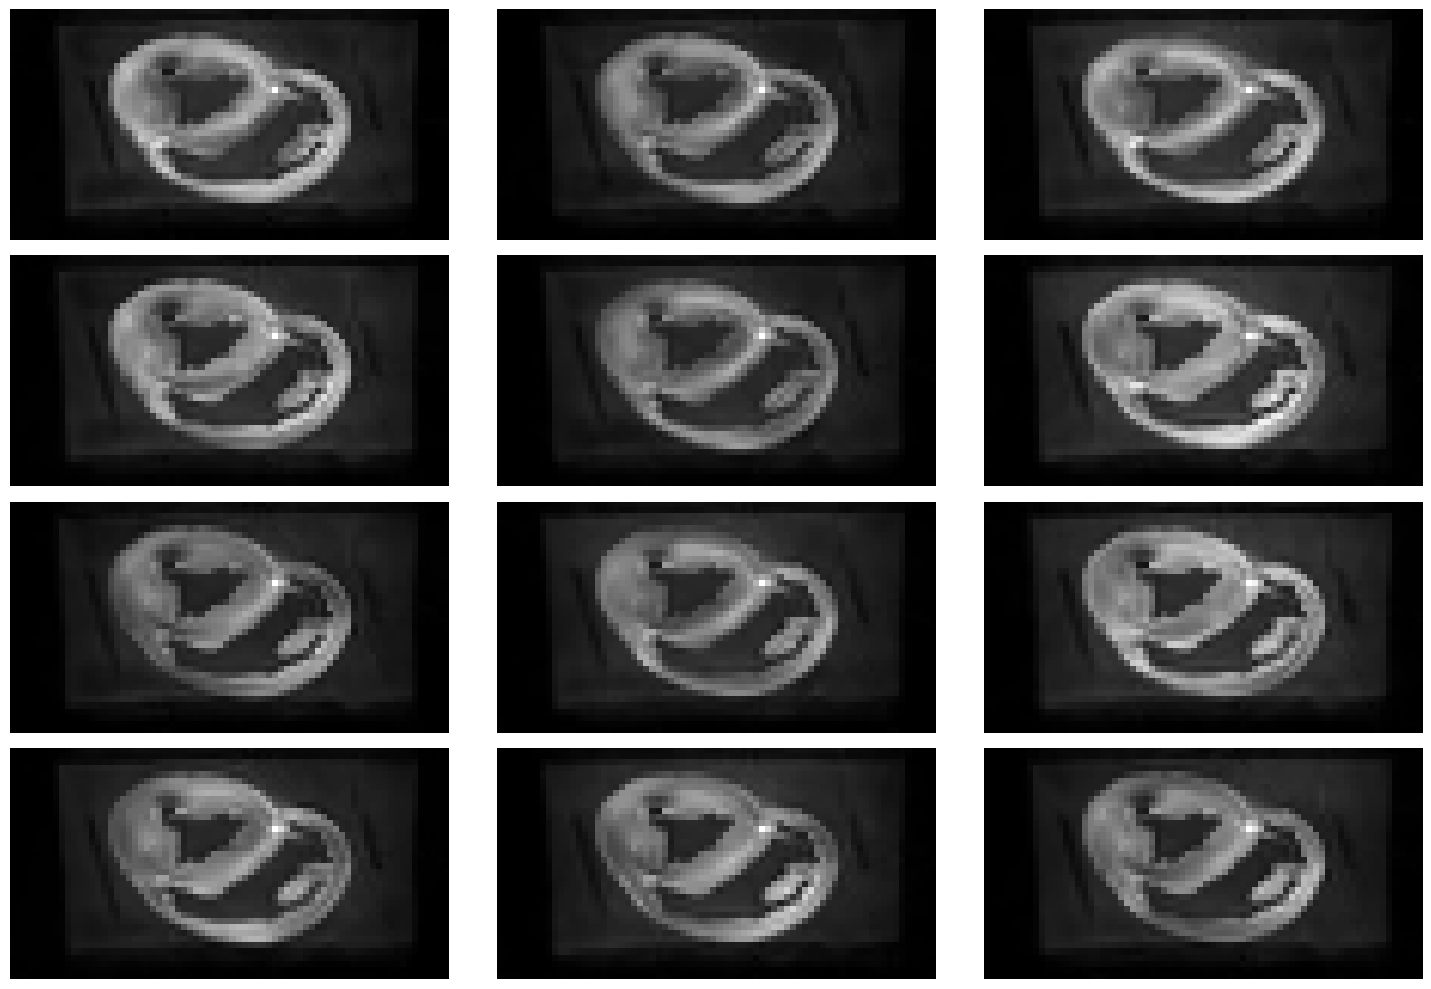

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, results_out3['best_param'])
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

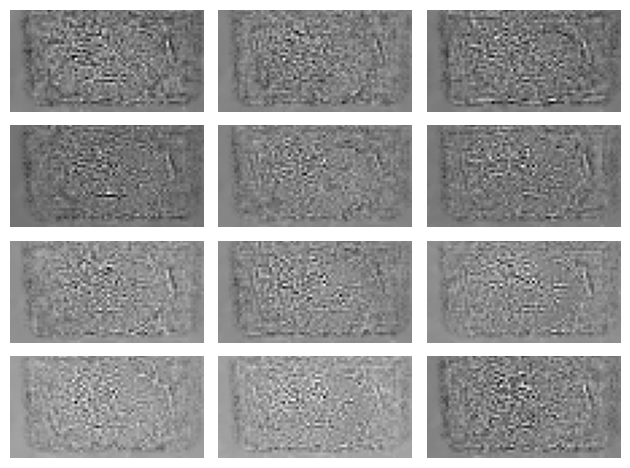

In [ ]:
from skimage.metrics import structural_similarity as ssim

for i, idx in enumerate(selected_dirs):
    plt.subplot(4, 3, i+1)

    inp = input[i]
    Img = ff_forwardpass(inp, params_cienmil_todo)
    Img = Img[:, 0] + 1j * Img[:, 1]
    I_img = np.abs(Img).reshape((Nx, Ny))

    gt_img = np.abs(slice[idx])
    img = gt_img  # ya tiene la forma correcta

    diff = I_img - img
    ssim_val = ssim(I_img, img, data_range=img.max() - img.min())

    plt.imshow(diff, cmap='gray')
    plt.title(f'SSIM: {ssim_val:.3f}')
    plt.axis('off')

plt.tight_layout()